In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

16908615680
0
0


In [2]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [4]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), 
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), 
        ], p=1),
        A.Resize(640, 480),  # Resize every image to 640x480 after all other transformations
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

In [5]:
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output  
    

In [6]:
class KPDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_file = self.imgs_files[idx]
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6')  

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [7]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
#         self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x


In [8]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.keypoint_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True, num_keypoints=6, num_classes=7)
#         self.gnn1 = VanillaGNN(2, 64, 64)
#         self.gnn2 = VanillaGNN(64, 64, 2)
#         self.gnn3 = VanillaGNN(64, 64, 2)
        self.graph_sage = GraphSAGE(2,64,2)
    
    def complete_missing_keypoints(self, keypoints, labels, num_expected_keypoints=6):

        detected_kps = keypoints.shape[0]
        # Check if all keypoints are detected
        if detected_kps == num_expected_keypoints:
            return keypoints

        # Create a placeholder tensor for keypoints with the correct shape
        ordered_keypoints = torch.zeros((num_expected_keypoints, 3), device=keypoints.device)

        # If some keypoints are detected, compute their average position
        average_kp = torch.mean(keypoints, dim=0, keepdim=True)

        for i, label in enumerate(labels):
            ordered_keypoints[label - 1] = keypoints[i]
            
        # Fill in the missing keypoints with the average position
        missing_indices = (torch.sum(ordered_keypoints, dim=1) == 0).nonzero(as_tuple=True)[0]
        ordered_keypoints[missing_indices] = average_kp
        
        return ordered_keypoints
           
    def get_edges(self):
        edges = [[0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 0]]
        return torch.tensor(edges, dtype=torch.long)
    

    def forward(self, images, adj_matrix=None, targets=None, train=False):
        if train:
            output = self.keypoint_rcnn(images, targets)
            return output
    
        else:
            all_keypoints = []
            with torch.no_grad():
                self.keypoint_rcnn.eval()
                output = self.keypoint_rcnn(images)
                self.keypoint_rcnn.train()
                
                keypoints = output[0]['keypoints'].detach().cpu().numpy()
                kp_score = output[0]['keypoints_scores'].detach().cpu().numpy()
                labels = output[0]['labels'].detach().cpu().numpy()
                unique_labels = list(set(labels))
                scores = output[0]['scores'].detach().cpu().numpy()
                print("labels", unique_labels)
                kps = []
                kp_scores = []
                ulabels = []

                for label in unique_labels:
                    indices = [j for j, x in enumerate(labels) if x == label]
                    scores_for_label = [scores[j] for j in indices]
                    max_score_index = indices[scores_for_label.index(max(scores_for_label))]
                    kp_score_label = kp_score[max_score_index].tolist()
                    kps.append(keypoints[max_score_index][kp_score_label.index(max(kp_score_label))])
                    ulabels.append(label)

                kps = [torch.tensor(kp, dtype=torch.float32) for kp in kps]
                if not kps:
                    default_value = torch.tensor([[320, 240, 1]], dtype=torch.float32, device=images[i].device)
                    keypoints = default_value.repeat(6, 1)
                else:
                    keypoints = torch.stack(kps)
                        
                print("kp before placeholder", keypoints)
                keypoints = self.complete_missing_keypoints(keypoints, unique_labels)[:, 0:2].to(device)
                print("kp after placeholder", keypoints)
                edges = self.get_edges()
                print("Edges", edges)
                data = Data(x=keypoints, edge_index=edges)
                keypoints = self.graph_sage(data.x.to(device), data.edge_index.to(device))
                print("kp after graph", keypoints)
            print("All keypoints", keypoints)

            return keypoints

In [9]:
def plot_training_loss(losses):
    """
    Plot the training loss over epochs.
    
    Args:
    - losses (list of float): The training loss for each epoch.
    """
    plt.plot(losses)
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the fu

ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [275.5892, 258.4950],
        [275.4606, 279.2654],
        [370.7963, 305.8671],
        [393.7273, 304.1852]], device='cuda:0')
labels [1, 3, 4, 5, 6]
kp before placeholder tensor([[290.8694, 279.8000,   1.0000],
        [145.5678, 267.5367,   1.0000],
        [268.2816, 270.7314,   1.0000],
        [400.5265, 321.0281,   1.0000],
        [265.8948, 246.8858,   1.0000]])
kp after placeholder tensor([[290.8694, 279.8000],
        [274.2280, 277.1964],
        [145.5678, 267.5367],
        [268.2816, 270.7314],
        [400.5265, 321.0281],
        [265.8948, 246.8858]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[256.5000,  97.2500],
        [ -1.6592, 170.0000],
        [101.8750, 210.8750],
        [100.5000, 147.1250],
        [177.0000, 306.2500],
        [ 76.8750, 130.1250]], device='cuda:0', dtype=torch.float16)
All keypoin

/home/jc-merlab/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/1, Batch 1/233, Loss: 49598.07421875
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [203.4095, 380.7241],
        [203.4811, 359.9531],
        [134.4066, 288.9979],
        [131.6875, 267.6523]], device='cuda:0')
labels [4, 5, 6]
kp before placeholder tensor([[334.7780, 366.2281,   1.0000],
        [160.8764, 304.2331,   1.0000],
        [144.2819, 255.9070,   1.0000]])
kp after placeholder tensor([[213.3121, 308.7894],
        [213.3121, 308.7894],
        [213.3121, 308.7894],
        [334.7780, 366.2281],
        [160.8764, 304.2331],
        [144.2819, 255.9070]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-23.4844,  58.1875],
        [ 88.0625, 244.3750],
        [162.3750, 187.1250],
        [174.6250, 155.6250],
        [ 47.0938, 107.2500],
        [ 91.6875, 230.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-23.4844,  58.1875],
        

Epoch 1/1, Batch 3/233, Loss: 35817.53515625
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
        [285.4656, 367.4533],
        [269.8876, 367.3220],
        [232.0105, 480.8661],
        [223.8008, 507.2216]], device='cuda:0')
labels [3, 4, 5]
kp before placeholder tensor([[327.9041, 109.2515,   1.0000],
        [303.0012, 159.9907,   1.0000],
        [275.3902, 186.7919,   1.0000]])
kp after placeholder tensor([[302.0985, 152.0114],
        [302.0985, 152.0114],
        [327.9041, 109.2515],
        [303.0012, 159.9907],
        [275.3902, 186.7919],
        [302.0985, 152.0114]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[106.8125, 187.3750],
        [118.3125, 154.1250],
        [-91.0000,   1.8203],
        [ 48.4062, 226.0000],
        [ 28.0469,  68.0625],
        [-30.8750,  14.5312]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[106.8125, 187.3750],
        

Epoch 1/1, Batch 5/233, Loss: 32450.4375
ground truth keypoints shape tensor([[193.4642, 489.2265],
        [193.4698, 377.3508],
        [134.7135, 396.7104],
        [131.8595, 369.4561],
        [173.2137, 259.8171],
        [185.5802, 278.7099]], device='cuda:0')
labels [3, 4, 5, 6]
kp before placeholder tensor([[198.4753, 449.7394,   1.0000],
        [170.0930, 468.3612,   1.0000],
        [160.2412, 550.2625,   1.0000],
        [154.6830, 336.4865,   1.0000]])
kp after placeholder tensor([[170.8731, 451.2124],
        [170.8731, 451.2124],
        [198.4753, 449.7394],
        [170.0930, 468.3612],
        [160.2412, 550.2625],
        [154.6830, 336.4865]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[145.8750, 137.8750],
        [ 51.8125,  79.3125],
        [179.0000, 373.5000],
        [ 52.0938,  48.0000],
        [ 53.9688, 329.2500],
        [ -1.0400, 247.2500]], device='cuda:0', dtype=torch.float16)
All keypoints

Epoch 1/1, Batch 7/233, Loss: 46898.0234375
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [206.8281, 357.9846],
        [212.8261, 338.1094],
        [300.0347, 291.1413],
        [286.4017, 275.4130]], device='cuda:0')
labels [1, 4, 5]
kp before placeholder tensor([[333.3527, 268.8273,   1.0000],
        [291.4316, 301.8293,   1.0000],
        [264.5506, 390.1562,   1.0000]])
kp after placeholder tensor([[333.3527, 268.8273],
        [296.4450, 320.2710],
        [296.4450, 320.2710],
        [291.4316, 301.8293],
        [264.5506, 390.1562],
        [296.4450, 320.2710]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 60.4062, -58.9375],
        [100.8125,  64.6250],
        [209.3750, 377.7500],
        [ 59.2188,  99.2500],
        [ 24.7344,  91.5625],
        [260.0000, 164.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 60.4062, -58.9375],
        [

Epoch 1/1, Batch 9/233, Loss: 44500.56640625
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
        [333.4884, 325.3881],
        [324.0876, 347.5129],
        [338.3143, 477.5003],
        [325.9014, 495.6003]], device='cuda:0')
labels [4, 5]
kp before placeholder tensor([[310.6566, 159.0265,   1.0000],
        [304.6970, 165.7655,   1.0000]])
kp after placeholder tensor([[307.6768, 162.3960],
        [307.6768, 162.3960],
        [307.6768, 162.3960],
        [310.6566, 159.0265],
        [304.6970, 165.7655],
        [307.6768, 162.3960]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 58.6562,  80.6250],
        [ 96.6875, 113.4375],
        [166.7500, 165.3750],
        [-55.8750,  60.0000],
        [ 39.2812, 169.1250],
        [ 73.4375,  55.4375]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 58.6562,  80.6250],
        [ 96.6875, 113.4375],
        [166.7500, 16

Epoch 1/1, Batch 11/233, Loss: 36731.25390625
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [207.4724, 355.9537],
        [214.0015, 336.2455],
        [130.1769, 283.7540],
        [114.9408, 299.0622]], device='cuda:0')
labels [1, 3, 4, 5, 6]
kp before placeholder tensor([[126.3911, 287.4279,   1.0000],
        [ 84.2532, 284.9032,   1.0000],
        [395.2093,  35.6551,   1.0000],
        [249.0524, 371.6290,   1.0000],
        [225.8987, 351.8183,   1.0000]])
kp after placeholder tensor([[126.3911, 287.4279],
        [216.1609, 266.2867],
        [ 84.2532, 284.9032],
        [395.2093,  35.6551],
        [249.0524, 371.6290],
        [225.8987, 351.8183]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[146.3750, 158.5000],
        [226.2500, 155.5000],
        [ 60.0312, 254.1250],
        [ 29.0312,  72.1250],
        [ 29.2188,  94.0000],
        [ 29.2500,  84.5625]], dev

Epoch 1/1, Batch 13/233, Loss: 45401.13671875
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [244.0275, 194.3309],
        [260.6254, 206.8581],
        [248.2235, 305.1776],
        [238.4880, 325.0677]], device='cuda:0')
labels [4, 5]
kp before placeholder tensor([[102.6485, 261.8657,   1.0000],
        [265.1388, 242.9163,   1.0000]])
kp after placeholder tensor([[183.8937, 252.3910],
        [183.8937, 252.3910],
        [183.8937, 252.3910],
        [102.6485, 261.8657],
        [265.1388, 242.9163],
        [183.8937, 252.3910]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 10.5000, 281.2500],
        [-22.6406, 129.3750],
        [  1.3994, 116.4375],
        [ 87.7500, 149.1250],
        [ 20.3906,  26.7031],
        [-90.3750, 146.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 10.5000, 281.2500],
        [-22.6406, 129.3750],
        [  1.3994, 1

Epoch 1/1, Batch 15/233, Loss: 36320.74609375
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [225.1776, 183.7581],
        [244.5336, 191.3603],
        [337.7916, 225.0241],
        [357.2643, 235.8485]], device='cuda:0')
labels [1, 3, 4, 5, 6]
kp before placeholder tensor([[326.8445, 217.7782,   1.0000],
        [343.2244, 262.9138,   1.0000],
        [ 98.9456, 259.2705,   1.0000],
        [288.7576, 188.2570,   1.0000],
        [347.2736, 214.6996,   1.0000]])
kp after placeholder tensor([[326.8445, 217.7782],
        [281.0092, 228.5838],
        [343.2244, 262.9138],
        [ 98.9456, 259.2705],
        [288.7576, 188.2570],
        [347.2736, 214.6996]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -9.4766, 176.8750],
        [ 53.7500,  18.3125],
        [-34.3438, 118.4375],
        [ 31.1875, 176.8750],
        [ 43.0312, 104.3125],
        [170.3750, 251.7500]], dev

Epoch 1/1, Batch 17/233, Loss: 41129.921875
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [203.4132, 381.9609],
        [203.1625, 361.1907],
        [253.1352, 275.7246],
        [272.8350, 266.8201]], device='cuda:0')
labels [4, 5, 6]
kp before placeholder tensor([[409.8902, 100.7138,   1.0000],
        [275.9936, 294.8160,   1.0000],
        [222.8797, 338.0133,   1.0000]])
kp after placeholder tensor([[302.9212, 244.5144],
        [302.9212, 244.5144],
        [302.9212, 244.5144],
        [409.8902, 100.7138],
        [275.9936, 294.8160],
        [222.8797, 338.0133]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -3.4180, 221.1250],
        [176.7500, 275.2500],
        [189.7500,  84.0625],
        [ 49.1875, 107.3750],
        [108.0000, 219.0000],
        [-13.5234,  96.1250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -3.4180, 221.1250],
        [

Epoch 1/1, Batch 19/233, Loss: 40499.35546875
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [243.9012, 194.2395],
        [260.5230, 206.7364],
        [353.9269, 240.1434],
        [353.9463, 261.9454]], device='cuda:0')
labels [4, 5, 6]
kp before placeholder tensor([[110.1624, 260.4532,   1.0000],
        [359.6987, 235.5314,   1.0000],
        [358.9960, 237.7237,   1.0000]])
kp after placeholder tensor([[276.2857, 244.5694],
        [276.2857, 244.5694],
        [276.2857, 244.5694],
        [110.1624, 260.4532],
        [359.6987, 235.5314],
        [358.9960, 237.7237]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-113.6250,  200.6250],
        [  30.9375,  100.7500],
        [ -32.1875,  149.3750],
        [  -7.2812,  129.2500],
        [  68.8750,  192.7500],
        [  36.0938,  121.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-113.6250,  200.

Epoch 1/1, Batch 21/233, Loss: 51868.75
ground truth keypoints shape tensor([[193.4642, 489.2265],
        [193.4698, 377.3508],
        [213.0168, 277.0745],
        [227.7339, 286.1220],
        [255.0150, 408.8965],
        [260.9036, 436.9088]], device='cuda:0')
labels [1, 3, 4, 5]
kp before placeholder tensor([[219.5429, 283.5147,   1.0000],
        [166.3496, 467.7439,   1.0000],
        [176.8520, 468.3424,   1.0000],
        [226.9621, 309.4660,   1.0000]])
kp after placeholder tensor([[219.5429, 283.5147],
        [197.4266, 382.2668],
        [166.3496, 467.7439],
        [176.8520, 468.3424],
        [226.9621, 309.4660],
        [197.4266, 382.2668]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 30.0781, 256.5000],
        [ 92.1250, 381.5000],
        [-46.1562, 135.7500],
        [-53.3438,  53.4062],
        [-48.0000, 126.0625],
        [ 23.6875, 304.7500]], device='cuda:0', dtype=torch.float16)
All keypoints 

Epoch 1/1, Batch 23/233, Loss: 57413.7109375
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [243.8961, 194.2353],
        [260.5190, 206.7306],
        [353.9121, 240.1718],
        [368.2176, 256.8177]], device='cuda:0')
labels [3, 4, 5, 6]
kp before placeholder tensor([[369.6021, 281.1013,   1.0000],
        [114.5922, 237.5925,   1.0000],
        [350.2340, 233.3382,   1.0000],
        [384.9943, 248.5503,   1.0000]])
kp after placeholder tensor([[304.8557, 250.1456],
        [304.8557, 250.1456],
        [369.6021, 281.1013],
        [114.5922, 237.5925],
        [350.2340, 233.3382],
        [384.9943, 248.5503]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-61.5000, 125.9375],
        [ 84.1875, 217.2500],
        [  7.6133,  99.6875],
        [175.2500, 134.1250],
        [ 54.4688, 257.2500],
        [-50.3125, 180.8750]], device='cuda:0', dtype=torch.float16)
All keypo

Epoch 1/1, Batch 25/233, Loss: 44255.828125
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [202.2059, 178.4394],
        [222.9440, 180.0383],
        [267.3412, 268.6408],
        [247.7452, 275.9309]], device='cuda:0')
labels [4, 5, 6]
kp before placeholder tensor([[103.9552, 260.9489,   1.0000],
        [248.6227, 212.6588,   1.0000],
        [225.7538, 174.9291,   1.0000]])
kp after placeholder tensor([[192.7773, 216.1789],
        [192.7773, 216.1789],
        [192.7773, 216.1789],
        [103.9552, 260.9489],
        [248.6227, 212.6588],
        [225.7538, 174.9291]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 127.9375,  166.8750],
        [ 104.3125,  104.8125],
        [-116.6875,   69.1250],
        [-111.3125,   49.2500],
        [ 104.6250,  152.6250],
        [ 117.7500,  197.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 127.9375,  166.87

Epoch 1/1, Batch 27/233, Loss: 49274.01171875
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [235.0576, 444.7277],
        [218.4441, 432.2200],
        [119.4574, 424.8057],
        [107.1440, 407.0467]], device='cuda:0')
labels [4, 5]
kp before placeholder tensor([[121.4792, 411.0120,   1.0000],
        [131.2526, 425.0601,   1.0000]])
kp after placeholder tensor([[126.3659, 418.0360],
        [126.3659, 418.0360],
        [126.3659, 418.0360],
        [121.4792, 411.0120],
        [131.2526, 425.0601],
        [126.3659, 418.0360]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -75.1250,   33.0938],
        [  -3.7637,  243.3750],
        [-154.0000,  164.2500],
        [ -78.1875,   76.6875],
        [ -81.5000,  280.0000],
        [ -33.3438,   96.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -75.1250,   33.0938],
        [  -3.7637,  243.3750],
    

Epoch 1/1, Batch 29/233, Loss: 62560.62109375
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [203.6987, 178.6049],
        [224.3993, 180.6023],
        [252.2867,  85.2606],
        [272.3589,  81.0036]], device='cuda:0')
labels [4, 5, 6]
kp before placeholder tensor([[ 99.4831, 260.4427,   1.0000],
        [284.3480,  83.6490,   1.0000],
        [241.4482,  93.4138,   1.0000]])
kp after placeholder tensor([[208.4264, 145.8352],
        [208.4264, 145.8352],
        [208.4264, 145.8352],
        [ 99.4831, 260.4427],
        [284.3480,  83.6490],
        [241.4482,  93.4138]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 84.5000,  12.4844],
        [ 14.7578, -40.5312],
        [-56.3750,  74.0000],
        [ 61.0312, 130.0000],
        [ 29.1875, 186.6250],
        [-48.7500,  60.5312]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 84.5000,  12.4844],
       

Epoch 1/1, Batch 31/233, Loss: 35252.91796875
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [271.4581, 232.5432],
        [278.0941, 252.2375],
        [352.7963, 317.3714],
        [350.1799, 338.6196]], device='cuda:0')
labels [3, 4, 5, 6]
kp before placeholder tensor([[113.9062, 261.6043,   1.0000],
        [121.1115, 249.6043,   1.0000],
        [350.7160, 285.4717,   1.0000],
        [297.9792, 231.8744,   1.0000]])
kp after placeholder tensor([[220.9282, 257.1387],
        [220.9282, 257.1387],
        [113.9062, 261.6043],
        [121.1115, 249.6043],
        [350.7160, 285.4717],
        [297.9792, 231.8744]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[172.0000,  38.4688],
        [ 98.6250, 226.2500],
        [-58.0000, 151.1250],
        [ 78.5625, 182.2500],
        [112.5625,  48.8125],
        [ 32.8750, 122.0000]], device='cuda:0', dtype=torch.float16)
All keyp

Epoch 1/1, Batch 33/233, Loss: 46587.890625
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
        [344.4664, 241.0124],
        [347.4651, 268.2241],
        [419.1943, 303.9874],
        [430.5388, 324.1598]], device='cuda:0')
labels [3, 4, 5, 6]
kp before placeholder tensor([[329.4731, 112.7547,   1.0000],
        [320.9193, 160.7556,   1.0000],
        [298.5465, 172.9460,   1.0000],
        [430.8142, 295.7596,   1.0000]])
kp after placeholder tensor([[344.9383, 185.5540],
        [344.9383, 185.5540],
        [329.4731, 112.7547],
        [320.9193, 160.7556],
        [298.5465, 172.9460],
        [430.8142, 295.7596]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 19.6094, 100.0625],
        [-50.8125, 229.2500],
        [ 58.6875,  59.1250],
        [ 75.8125, 198.7500],
        [ 87.5000, 181.7500],
        [131.8750,  81.9375]], device='cuda:0', dtype=torch.float16)
All keypoi

Epoch 1/1, Batch 35/233, Loss: 48574.953125
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [276.7260, 460.5497],
        [255.9896, 458.9300],
        [161.2191, 429.9053],
        [146.0472, 413.8364]], device='cuda:0')
labels [1, 4, 5, 6]
kp before placeholder tensor([[384.6192, 452.7973,   1.0000],
        [160.5696, 418.4076,   1.0000],
        [321.1412, 400.7403,   1.0000],
        [158.9008, 410.6328,   1.0000]])
kp after placeholder tensor([[384.6192, 452.7973],
        [256.3077, 420.6445],
        [256.3077, 420.6445],
        [160.5696, 418.4076],
        [321.1412, 400.7403],
        [158.9008, 410.6328]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[208.6250, 305.7500],
        [ 42.6562, 124.2500],
        [ 60.2812, 334.2500],
        [ 18.2344, 251.3750],
        [-84.0000, 109.5625],
        [147.2500,  73.3125]], device='cuda:0', dtype=torch.float16)
All keypoi

Epoch 1/1, Batch 37/233, Loss: 52208.11328125
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
        [266.2852, 361.6241],
        [251.5634, 352.6007],
        [206.8613, 247.1914],
        [209.9689, 219.7049]], device='cuda:0')
labels [3, 4, 5]
kp before placeholder tensor([[327.0195, 109.9895,   1.0000],
        [244.0577, 352.1375,   1.0000],
        [285.1497, 195.9902,   1.0000]])
kp after placeholder tensor([[285.4090, 219.3724],
        [285.4090, 219.3724],
        [327.0195, 109.9895],
        [244.0577, 352.1375],
        [285.1497, 195.9902],
        [285.4090, 219.3724]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[109.1250,  79.8125],
        [ -4.6094, 140.0000],
        [174.5000, 107.5625],
        [309.5000, 320.0000],
        [ 78.7500, 222.7500],
        [-12.0625, 182.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[109.1250,  79.8125],
       

Epoch 1/1, Batch 39/233, Loss: 38460.98828125
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
        [345.3935, 270.0033],
        [344.1333, 297.6444],
        [361.6154, 426.2679],
        [362.5142, 455.9648]], device='cuda:0')
labels [3, 4, 5]
kp before placeholder tensor([[328.5201, 101.6210,   1.0000],
        [308.8539, 157.4405,   1.0000],
        [289.9365, 196.1458,   1.0000]])
kp after placeholder tensor([[309.1035, 151.7357],
        [309.1035, 151.7357],
        [328.5201, 101.6210],
        [308.8539, 157.4405],
        [289.9365, 196.1458],
        [309.1035, 151.7357]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[190.3750, -33.6875],
        [162.0000, 170.6250],
        [ -2.3301, 100.6875],
        [ 23.3125, 106.0000],
        [169.2500, 253.3750],
        [-31.6406, 116.8125]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[190.3750, -33.6875],
       

Epoch 1/1, Batch 41/233, Loss: 46602.515625
ground truth keypoints shape tensor([[193.4642, 489.2265],
        [193.4698, 377.3508],
        [193.4234, 271.2114],
        [209.0019, 271.1757],
        [273.6606, 206.1999],
        [289.7315, 209.7357]], device='cuda:0')
labels [3, 4, 5]
kp before placeholder tensor([[194.5613, 463.7193,   1.0000],
        [178.7486, 477.4944,   1.0000],
        [163.5238, 554.1683,   1.0000]])
kp after placeholder tensor([[178.9445, 498.4607],
        [178.9445, 498.4607],
        [194.5613, 463.7193],
        [178.7486, 477.4944],
        [163.5238, 554.1683],
        [178.9445, 498.4607]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-197.6250,  258.5000],
        [-100.2500,  226.1250],
        [ 245.5000,   36.2812],
        [ 188.5000,  316.7500],
        [-170.3750,  349.2500],
        [  52.5625,   82.3125]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-197.6250,  258.50

Epoch 1/1, Batch 43/233, Loss: 40467.015625
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [275.9215, 460.4649],
        [255.2045, 458.6312],
        [183.4120, 527.3054],
        [163.2430, 520.6083]], device='cuda:0')
labels [4, 5, 6]
kp before placeholder tensor([[409.8861, 102.3250,   1.0000],
        [147.0135, 515.2369,   1.0000],
        [345.2732, 357.1246,   1.0000]])
kp after placeholder tensor([[300.7243, 324.8955],
        [300.7243, 324.8955],
        [300.7243, 324.8955],
        [409.8861, 102.3250],
        [147.0135, 515.2369],
        [345.2732, 357.1246]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 61.0938, 123.0625],
        [ 18.6250,  45.8750],
        [161.2500, 157.8750],
        [354.5000, 156.3750],
        [ 61.8125,  48.2188],
        [114.9375, 203.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 61.0938, 123.0625],
        [

Epoch 1/1, Batch 45/233, Loss: 41275.765625
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [235.0647, 444.7383],
        [218.4488, 432.2339],
        [178.5034, 341.5541],
        [184.1212, 320.3138]], device='cuda:0')
labels [4, 5, 6]
kp before placeholder tensor([[397.6151, 106.4885,   1.0000],
        [178.1057, 335.5733,   1.0000],
        [172.8697, 303.0252,   1.0000]])
kp after placeholder tensor([[249.5302, 248.3624],
        [249.5302, 248.3624],
        [249.5302, 248.3624],
        [397.6151, 106.4885],
        [178.1057, 335.5733],
        [172.8697, 303.0252]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 193.5000,  179.2500],
        [ -29.5938,   79.1250],
        [ 121.8750,  161.8750],
        [-115.3125,   58.0312],
        [ -38.7812,  238.7500],
        [  20.1406,  203.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 193.5000,  179.25

labels [1, 3, 4, 5]
kp before placeholder tensor([[ 84.4319, 154.9128,   1.0000],
        [191.4220, 462.8837,   1.0000],
        [178.7507, 482.7046,   1.0000],
        [160.9982, 567.0638,   1.0000]])
kp after placeholder tensor([[ 84.4319, 154.9128],
        [153.9007, 416.8912],
        [191.4220, 462.8837],
        [178.7507, 482.7046],
        [160.9982, 567.0638],
        [153.9007, 416.8912]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  7.2500,  47.4375],
        [ 44.0625, 222.7500],
        [-51.3750, 256.5000],
        [-74.9375,  84.8750],
        [ 76.5000, 393.2500],
        [ 95.8750, 125.9375]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  7.2500,  47.4375],
        [ 44.0625, 222.7500],
        [-51.3750, 256.5000],
        [-74.9375,  84.8750],
        [ 76.5000, 393.2500],
        [ 95.8750, 125.9375]], device='cuda:0', dtype=torch.float16)
total_loss tensor(41795.0352, device='cuda:0', g

labels [3, 4, 5]
kp before placeholder tensor([[328.2218, 101.6959,   1.0000],
        [309.0135, 158.9858,   1.0000],
        [286.1494, 196.7973,   1.0000]])
kp after placeholder tensor([[307.7949, 152.4930],
        [307.7949, 152.4930],
        [328.2218, 101.6959],
        [309.0135, 158.9858],
        [286.1494, 196.7973],
        [307.7949, 152.4930]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[154.8750, 144.8750],
        [-49.5625, 167.6250],
        [107.8125, 106.1875],
        [ 93.7500, 173.6250],
        [239.8750, 268.7500],
        [ -3.9844, 148.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[154.8750, 144.8750],
        [-49.5625, 167.6250],
        [107.8125, 106.1875],
        [ 93.7500, 173.6250],
        [239.8750, 268.7500],
        [ -3.9844, 148.8750]], device='cuda:0', dtype=torch.float16)
total_loss tensor(39063.5938, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 49/

labels [4, 5, 6]
kp before placeholder tensor([[411.0505, 107.8990,   1.0000],
        [214.0550, 234.1909,   1.0000],
        [230.1481, 211.5677,   1.0000]])
kp after placeholder tensor([[285.0845, 184.5525],
        [285.0845, 184.5525],
        [285.0845, 184.5525],
        [411.0505, 107.8990],
        [214.0550, 234.1909],
        [230.1481, 211.5677]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[132.5000, 265.0000],
        [  7.4180, 170.2500],
        [ 84.6250, 161.3750],
        [141.7500, 133.6250],
        [127.8750,  -5.6055],
        [ 40.7812,  66.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[132.5000, 265.0000],
        [  7.4180, 170.2500],
        [ 84.6250, 161.3750],
        [141.7500, 133.6250],
        [127.8750,  -5.6055],
        [ 40.7812,  66.8750]], device='cuda:0', dtype=torch.float16)
total_loss tensor(36728.3906, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 51/

labels [1, 4, 5, 6]
kp before placeholder tensor([[374.9304, 424.3806,   1.0000],
        [229.5137, 321.5816,   1.0000],
        [263.7792, 365.5992,   1.0000],
        [261.4504, 304.2344,   1.0000]])
kp after placeholder tensor([[374.9304, 424.3806],
        [282.4184, 353.9489],
        [282.4184, 353.9489],
        [229.5137, 321.5816],
        [263.7792, 365.5992],
        [261.4504, 304.2344]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-43.3438, 149.8750],
        [223.0000, 319.7500],
        [  9.8594, 152.2500],
        [ 62.4375, 161.8750],
        [129.6250, 255.0000],
        [132.7500, 222.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-43.3438, 149.8750],
        [223.0000, 319.7500],
        [  9.8594, 152.2500],
        [ 62.4375, 161.8750],
        [129.6250, 255.0000],
        [132.7500, 222.7500]], device='cuda:0', dtype=torch.float16)
total_loss tensor(40424.8320, device='cuda:0', g

labels [3, 4, 5]
kp before placeholder tensor([[191.7226, 456.8990,   1.0000],
        [178.7543, 483.0039,   1.0000],
        [160.9943, 567.3632,   1.0000]])
kp after placeholder tensor([[177.1571, 502.4220],
        [177.1571, 502.4220],
        [191.7226, 456.8990],
        [178.7543, 483.0039],
        [160.9943, 567.3632],
        [177.1571, 502.4220]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-28.2188, -28.5469],
        [ 58.7812, 178.3750],
        [159.5000, 362.2500],
        [ -4.4570, 128.7500],
        [137.8750, 253.7500],
        [ 58.2500, 273.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-28.2188, -28.5469],
        [ 58.7812, 178.3750],
        [159.5000, 362.2500],
        [ -4.4570, 128.7500],
        [137.8750, 253.7500],
        [ 58.2500, 273.2500]], device='cuda:0', dtype=torch.float16)
total_loss tensor(45201.6758, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 55/

labels [3, 4, 5]
kp before placeholder tensor([[191.4307, 455.4224,   1.0000],
        [177.7937, 483.6048,   1.0000],
        [161.1466, 567.3687,   1.0000]])
kp after placeholder tensor([[176.7903, 502.1319],
        [176.7903, 502.1319],
        [191.4307, 455.4224],
        [177.7937, 483.6048],
        [161.1466, 567.3687],
        [176.7903, 502.1319]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  50.9375,  222.3750],
        [-189.3750,  178.8750],
        [ -19.6406,   69.3125],
        [ 122.2500,  137.6250],
        [ -52.7188,  282.2500],
        [-156.0000,  321.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  50.9375,  222.3750],
        [-189.3750,  178.8750],
        [ -19.6406,   69.3125],
        [ 122.2500,  137.6250],
        [ -52.7188,  282.2500],
        [-156.0000,  321.0000]], device='cuda:0', dtype=torch.float16)
total_loss tensor(41507.3711, device='cuda:0', grad_fn=<AddBackward

labels [3, 4, 5]
kp before placeholder tensor([[320.3873,  18.8876,   1.0000],
        [304.4754, 155.5479,   1.0000],
        [290.4259, 184.5053,   1.0000]])
kp after placeholder tensor([[305.0962, 119.6469],
        [305.0962, 119.6469],
        [320.3873,  18.8876],
        [304.4754, 155.5479],
        [290.4259, 184.5053],
        [305.0962, 119.6469]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 75.6875, 149.5000],
        [ 62.3438,  23.5781],
        [-19.9062, 139.1250],
        [ 48.1562,  98.7500],
        [120.6250, 141.8750],
        [ 18.3594,  49.3438]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 75.6875, 149.5000],
        [ 62.3438,  23.5781],
        [-19.9062, 139.1250],
        [ 48.1562,  98.7500],
        [120.6250, 141.8750],
        [ 18.3594,  49.3438]], device='cuda:0', dtype=torch.float16)
total_loss tensor(41147.7617, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 59/

labels [3, 4, 5]
kp before placeholder tensor([[194.7117, 463.7064,   1.0000],
        [179.3943, 464.2031,   1.0000],
        [160.0858, 551.5002,   1.0000]])
kp after placeholder tensor([[178.0639, 493.1366],
        [178.0639, 493.1366],
        [194.7117, 463.7064],
        [179.3943, 464.2031],
        [160.0858, 551.5002],
        [178.0639, 493.1366]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-234.6250,  192.2500],
        [  17.7031,  323.5000],
        [  17.1250,  -54.0000],
        [ 159.6250,   63.0625],
        [ 135.7500,  244.1250],
        [-332.2500,  337.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-234.6250,  192.2500],
        [  17.7031,  323.5000],
        [  17.1250,  -54.0000],
        [ 159.6250,   63.0625],
        [ 135.7500,  244.1250],
        [-332.2500,  337.0000]], device='cuda:0', dtype=torch.float16)
total_loss tensor(63925.0898, device='cuda:0', grad_fn=<AddBackward

labels [4, 5]
kp before placeholder tensor([[ 93.9523, 257.9233,   1.0000],
        [165.8907, 247.8924,   1.0000]])
kp after placeholder tensor([[129.9215, 252.9078],
        [129.9215, 252.9078],
        [129.9215, 252.9078],
        [ 93.9523, 257.9233],
        [165.8907, 247.8924],
        [129.9215, 252.9078]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 48.1875,  57.5938],
        [ 46.6562, 175.2500],
        [113.5000, 151.2500],
        [ 88.1875, 127.5000],
        [ -5.1016, 123.9375],
        [152.8750, 137.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 48.1875,  57.5938],
        [ 46.6562, 175.2500],
        [113.5000, 151.2500],
        [ 88.1875, 127.5000],
        [ -5.1016, 123.9375],
        [152.8750, 137.6250]], device='cuda:0', dtype=torch.float16)
total_loss tensor(35368.1289, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 63/233, Loss: 35368.12890625
ground truth keyp

labels [1, 3, 4, 5, 6]
kp before placeholder tensor([[240.7562, 342.7700,   1.0000],
        [179.0960, 451.1719,   1.0000],
        [177.0249, 461.7121,   1.0000],
        [173.3899, 557.4376,   1.0000],
        [235.6969, 332.7955,   1.0000]])
kp after placeholder tensor([[240.7562, 342.7700],
        [201.1927, 429.1774],
        [179.0960, 451.1719],
        [177.0249, 461.7121],
        [173.3899, 557.4376],
        [235.6969, 332.7955]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  52.8438,   53.1875],
        [ 181.5000,  229.3750],
        [ 151.0000,  343.2500],
        [-252.1250,  168.0000],
        [  87.0000,  212.3750],
        [ -35.0000,  280.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  52.8438,   53.1875],
        [ 181.5000,  229.3750],
        [ 151.0000,  343.2500],
        [-252.1250,  168.0000],
        [  87.0000,  212.3750],
        [ -35.0000,  280.2500]], device='cuda:0', dt

labels [4, 5]
kp before placeholder tensor([[397.6355, 105.0998,   1.0000],
        [338.9920, 419.6611,   1.0000]])
kp after placeholder tensor([[368.3138, 262.3804],
        [368.3138, 262.3804],
        [368.3138, 262.3804],
        [397.6355, 105.0998],
        [338.9920, 419.6611],
        [368.3138, 262.3804]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  5.4141, 191.7500],
        [ -7.8906,  94.7500],
        [ -5.4727, 134.7500],
        [ 14.2188, 129.3750],
        [124.8125, 178.2500],
        [128.6250,  32.5312]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  5.4141, 191.7500],
        [ -7.8906,  94.7500],
        [ -5.4727, 134.7500],
        [ 14.2188, 129.3750],
        [124.8125, 178.2500],
        [128.6250,  32.5312]], device='cuda:0', dtype=torch.float16)
total_loss tensor(34806.4023, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 67/233, Loss: 34806.40234375
ground truth keyp

labels [3, 4, 5]
kp before placeholder tensor([[332.3941, 107.2603,   1.0000],
        [308.8338, 159.2470,   1.0000],
        [289.3426, 195.6218,   1.0000]])
kp after placeholder tensor([[310.1902, 154.0430],
        [310.1902, 154.0430],
        [332.3941, 107.2603],
        [308.8338, 159.2470],
        [289.3426, 195.6218],
        [310.1902, 154.0430]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -9.0234,  32.7812],
        [  6.6641,  22.0781],
        [180.7500, 235.7500],
        [-53.5000, 208.8750],
        [230.3750, 192.8750],
        [ 99.0625,   6.1289]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -9.0234,  32.7812],
        [  6.6641,  22.0781],
        [180.7500, 235.7500],
        [-53.5000, 208.8750],
        [230.3750, 192.8750],
        [ 99.0625,   6.1289]], device='cuda:0', dtype=torch.float16)
total_loss tensor(48081.6914, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 69/

labels [3, 4, 5]
kp before placeholder tensor([[191.8639, 462.2109,   1.0000],
        [179.3945, 474.8799,   1.0000],
        [140.4815, 172.9181,   1.0000]])
kp after placeholder tensor([[170.5800, 370.0030],
        [170.5800, 370.0030],
        [191.8639, 462.2109],
        [179.3945, 474.8799],
        [140.4815, 172.9181],
        [170.5800, 370.0030]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -31.8125,  200.3750],
        [-139.2500,   83.8125],
        [ 123.3125,  306.7500],
        [ -18.6094,  173.1250],
        [  65.6250,  258.0000],
        [  35.6562,   64.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -31.8125,  200.3750],
        [-139.2500,   83.8125],
        [ 123.3125,  306.7500],
        [ -18.6094,  173.1250],
        [  65.6250,  258.0000],
        [  35.6562,   64.7500]], device='cuda:0', dtype=torch.float16)
total_loss tensor(46918.1328, device='cuda:0', grad_fn=<AddBackward

labels [4, 5, 6]
kp before placeholder tensor([[317.8238, 123.8486,   1.0000],
        [316.4598, 105.3802,   1.0000],
        [316.8329, 111.0614,   1.0000]])
kp after placeholder tensor([[317.0388, 113.4301],
        [317.0388, 113.4301],
        [317.0388, 113.4301],
        [317.8238, 123.8486],
        [316.4598, 105.3802],
        [316.8329, 111.0614]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-24.0312,  91.6875],
        [ 78.8750, 266.2500],
        [ 28.8438, -64.6875],
        [ 33.6562,  95.1250],
        [ 18.3594, -32.0312],
        [  3.0000,  85.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-24.0312,  91.6875],
        [ 78.8750, 266.2500],
        [ 28.8438, -64.6875],
        [ 33.6562,  95.1250],
        [ 18.3594, -32.0312],
        [  3.0000,  85.7500]], device='cuda:0', dtype=torch.float16)
total_loss tensor(44513.5078, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 73/

labels [4, 5, 6]
kp before placeholder tensor([[103.5842, 266.3730,   1.0000],
        [366.8520, 247.7633,   1.0000],
        [367.1440, 246.5252,   1.0000]])
kp after placeholder tensor([[279.1934, 253.5538],
        [279.1934, 253.5538],
        [279.1934, 253.5538],
        [103.5842, 266.3730],
        [366.8520, 247.7633],
        [367.1440, 246.5252]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 45.5938,  56.2500],
        [235.2500,  98.6875],
        [ 64.2500,  92.3125],
        [160.0000, 140.3750],
        [148.7500,  18.5156],
        [-29.8125,  58.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 45.5938,  56.2500],
        [235.2500,  98.6875],
        [ 64.2500,  92.3125],
        [160.0000, 140.3750],
        [148.7500,  18.5156],
        [-29.8125,  58.2500]], device='cuda:0', dtype=torch.float16)
total_loss tensor(39264.4219, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 75/

labels [4, 5, 6]
kp before placeholder tensor([[120.4879, 249.4458,   1.0000],
        [328.0319, 229.7976,   1.0000],
        [369.1555, 214.0065,   1.0000]])
kp after placeholder tensor([[272.5584, 231.0833],
        [272.5584, 231.0833],
        [272.5584, 231.0833],
        [120.4879, 249.4458],
        [328.0319, 229.7976],
        [369.1555, 214.0065]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-13.4844, -57.0938],
        [-76.4375,  28.6875],
        [-53.2188, 107.8125],
        [106.7500,  50.6562],
        [ 33.8438, 153.7500],
        [ 23.9375,  74.8125]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-13.4844, -57.0938],
        [-76.4375,  28.6875],
        [-53.2188, 107.8125],
        [106.7500,  50.6562],
        [ 33.8438, 153.7500],
        [ 23.9375,  74.8125]], device='cuda:0', dtype=torch.float16)
total_loss tensor(49684.1016, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 77/

labels [3, 4, 5]
kp before placeholder tensor([[194.5920, 463.7079,   1.0000],
        [175.6380, 477.8198,   1.0000],
        [166.5292, 554.4705,   1.0000]])
kp after placeholder tensor([[178.9197, 498.6660],
        [178.9197, 498.6660],
        [194.5920, 463.7079],
        [175.6380, 477.8198],
        [166.5292, 554.4705],
        [178.9197, 498.6660]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  41.0938,  225.8750],
        [-273.7500,  262.5000],
        [   6.8438,   66.7500],
        [ -38.4688,  268.2500],
        [ 192.2500,  300.5000],
        [-100.6250,  -36.3125]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  41.0938,  225.8750],
        [-273.7500,  262.5000],
        [   6.8438,   66.7500],
        [ -38.4688,  268.2500],
        [ 192.2500,  300.5000],
        [-100.6250,  -36.3125]], device='cuda:0', dtype=torch.float16)
total_loss tensor(45150.0977, device='cuda:0', grad_fn=<AddBackward

labels [3, 4, 5]
kp before placeholder tensor([[320.3948,  16.5582,   1.0000],
        [304.1869, 162.8279,   1.0000],
        [290.1097, 185.8263,   1.0000]])
kp after placeholder tensor([[304.8972, 121.7375],
        [304.8972, 121.7375],
        [320.3948,  16.5582],
        [304.1869, 162.8279],
        [290.1097, 185.8263],
        [304.8972, 121.7375]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[194.2500,  28.8906],
        [ 47.3438,  72.7500],
        [-10.9375,  -5.9336],
        [ 66.8125, 163.1250],
        [ 24.1250,  78.3750],
        [108.0000, 126.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[194.2500,  28.8906],
        [ 47.3438,  72.7500],
        [-10.9375,  -5.9336],
        [ 66.8125, 163.1250],
        [ 24.1250,  78.3750],
        [108.0000, 126.6250]], device='cuda:0', dtype=torch.float16)
total_loss tensor(62684.6133, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 81/

labels [1, 4, 5, 6]
kp before placeholder tensor([[295.4729, 277.5049,   1.0000],
        [267.6033, 362.6535,   1.0000],
        [309.2754, 282.6527,   1.0000],
        [300.6241, 247.6322,   1.0000]])
kp after placeholder tensor([[295.4729, 277.5049],
        [293.2439, 292.6108],
        [293.2439, 292.6108],
        [267.6033, 362.6535],
        [309.2754, 282.6527],
        [300.6241, 247.6322]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[132.2500, 280.2500],
        [ 79.6875, 188.0000],
        [176.6250,  95.3125],
        [ -3.3516,  29.5312],
        [ 49.7500, 143.5000],
        [149.6250,  94.5625]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[132.2500, 280.2500],
        [ 79.6875, 188.0000],
        [176.6250,  95.3125],
        [ -3.3516,  29.5312],
        [ 49.7500, 143.5000],
        [149.6250,  94.5625]], device='cuda:0', dtype=torch.float16)
total_loss tensor(40559.9219, device='cuda:0', g

labels [3, 4, 5]
kp before placeholder tensor([[303.3636, 167.9028,   1.0000],
        [308.9201, 157.7287,   1.0000],
        [279.9914, 193.2392,   1.0000]])
kp after placeholder tensor([[297.4251, 172.9569],
        [297.4251, 172.9569],
        [303.3636, 167.9028],
        [308.9201, 157.7287],
        [279.9914, 193.2392],
        [297.4251, 172.9569]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 47.1562,   5.8555],
        [ 66.7500, 169.6250],
        [ 75.6250, 134.5000],
        [-21.0000,  77.6875],
        [151.1250, 146.7500],
        [ 17.9844,  81.0625]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 47.1562,   5.8555],
        [ 66.7500, 169.6250],
        [ 75.6250, 134.5000],
        [-21.0000,  77.6875],
        [151.1250, 146.7500],
        [ 17.9844,  81.0625]], device='cuda:0', dtype=torch.float16)
total_loss tensor(39111.5273, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 85/

labels [4, 5, 6]
kp before placeholder tensor([[397.9297, 109.6307,   1.0000],
        [340.7921, 419.3580,   1.0000],
        [127.1508, 488.0080,   1.0000]])
kp after placeholder tensor([[288.6242, 338.9989],
        [288.6242, 338.9989],
        [288.6242, 338.9989],
        [397.9297, 109.6307],
        [340.7921, 419.3580],
        [127.1508, 488.0080]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-89.9375, 127.3750],
        [ 40.7500, 261.7500],
        [-87.3750, 291.0000],
        [113.0000,  74.3750],
        [127.4375, 204.1250],
        [120.6250, 182.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-89.9375, 127.3750],
        [ 40.7500, 261.7500],
        [-87.3750, 291.0000],
        [113.0000,  74.3750],
        [127.4375, 204.1250],
        [120.6250, 182.2500]], device='cuda:0', dtype=torch.float16)
total_loss tensor(46534.0977, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 87/

labels [3, 4, 5]
kp before placeholder tensor([[301.2179, 169.1502,   1.0000],
        [287.6558, 212.0166,   1.0000],
        [288.4142, 190.0886,   1.0000]])
kp after placeholder tensor([[292.4294, 190.4185],
        [292.4294, 190.4185],
        [301.2179, 169.1502],
        [287.6558, 212.0166],
        [288.4142, 190.0886],
        [292.4294, 190.4185]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 23.7031,  96.0000],
        [234.5000, 165.3750],
        [ 77.3125,  93.7500],
        [-58.8125, 143.7500],
        [-19.5469,  90.0000],
        [ -9.4844,  41.5625]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 23.7031,  96.0000],
        [234.5000, 165.3750],
        [ 77.3125,  93.7500],
        [-58.8125, 143.7500],
        [-19.5469,  90.0000],
        [ -9.4844,  41.5625]], device='cuda:0', dtype=torch.float16)
total_loss tensor(50431.3867, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 89/

labels [3, 4, 5]
kp before placeholder tensor([[320.3911,  18.8834,   1.0000],
        [309.0836, 159.5167,   1.0000],
        [290.6987, 184.5114,   1.0000]])
kp after placeholder tensor([[306.7245, 120.9705],
        [306.7245, 120.9705],
        [320.3911,  18.8834],
        [309.0836, 159.5167],
        [290.6987, 184.5114],
        [306.7245, 120.9705]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[120.8750, 204.1250],
        [  9.5781,  46.5625],
        [-21.3281, 134.1250],
        [ 44.3750,  76.0000],
        [150.6250, 100.5000],
        [179.6250,  27.4844]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[120.8750, 204.1250],
        [  9.5781,  46.5625],
        [-21.3281, 134.1250],
        [ 44.3750,  76.0000],
        [150.6250, 100.5000],
        [179.6250,  27.4844]], device='cuda:0', dtype=torch.float16)
total_loss tensor(44451.6016, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 91/

labels [4, 5, 6]
kp before placeholder tensor([[102.3248, 262.0174,   1.0000],
        [356.7013, 311.0411,   1.0000],
        [336.5511, 314.6654,   1.0000]])
kp after placeholder tensor([[265.1924, 295.9080],
        [265.1924, 295.9080],
        [265.1924, 295.9080],
        [102.3248, 262.0174],
        [356.7013, 311.0411],
        [336.5511, 314.6654]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-104.4375,  155.7500],
        [  81.3125,  133.5000],
        [ 118.0625,  294.2500],
        [ 103.5625,  176.0000],
        [ -96.3750,   53.7812],
        [ -93.3125,  117.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-104.4375,  155.7500],
        [  81.3125,  133.5000],
        [ 118.0625,  294.2500],
        [ 103.5625,  176.0000],
        [ -96.3750,   53.7812],
        [ -93.3125,  117.6250]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        

labels [2, 3, 4, 5, 6]
kp before placeholder tensor([[191.9408, 307.3857,   1.0000],
        [308.4656, 159.8405,   1.0000],
        [318.8363, 157.5580,   1.0000],
        [305.2539, 170.9026,   1.0000],
        [261.3556, 344.3064,   1.0000]])
kp after placeholder tensor([[277.1704, 227.9986],
        [191.9408, 307.3857],
        [308.4656, 159.8405],
        [318.8363, 157.5580],
        [305.2539, 170.9026],
        [261.3556, 344.3064]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 86.0000,  83.0625],
        [-32.0625, 317.5000],
        [-77.3750,  55.5312],
        [ 25.5938, 155.2500],
        [130.0000,  85.8750],
        [ 28.2969, 296.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 86.0000,  83.0625],
        [-32.0625, 317.5000],
        [-77.3750,  55.5312],
        [ 25.5938, 155.2500],
        [130.0000,  85.8750],
        [ 28.2969, 296.2500]], device='cuda:0', dtype=torch.float16)
groun

labels [1, 4, 5, 6]
kp before placeholder tensor([[375.8339, 423.7726,   1.0000],
        [226.8367, 340.3229,   1.0000],
        [256.4433, 221.2281,   1.0000],
        [254.5835, 313.9685,   1.0000]])
kp after placeholder tensor([[375.8339, 423.7726],
        [278.4243, 324.8230],
        [278.4243, 324.8230],
        [226.8367, 340.3229],
        [256.4433, 221.2281],
        [254.5835, 313.9685]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 291.7500,  119.8125],
        [-271.5000,  182.6250],
        [ 167.7500,  324.7500],
        [ 160.3750,  212.0000],
        [ 145.8750,  110.7500],
        [-113.0000,  144.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 291.7500,  119.8125],
        [-271.5000,  182.6250],
        [ 167.7500,  324.7500],
        [ 160.3750,  212.0000],
        [ 145.8750,  110.7500],
        [-113.0000,  144.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [3, 4, 5, 6]
kp before placeholder tensor([[196.4983, 460.8562,   1.0000],
        [178.4385, 477.1777,   1.0000],
        [163.5220, 554.4682,   1.0000],
        [133.6885, 309.7451,   1.0000]])
kp after placeholder tensor([[168.0369, 450.5618],
        [168.0369, 450.5618],
        [196.4983, 460.8562],
        [178.4385, 477.1777],
        [163.5220, 554.4682],
        [133.6885, 309.7451]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 104.1875,  109.3125],
        [  80.0625,  122.5000],
        [ -18.9062,  228.7500],
        [ -87.1875,  176.7500],
        [-101.1250,  176.8750],
        [ 122.2500,  -16.9688]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 104.1875,  109.3125],
        [  80.0625,  122.5000],
        [ -18.9062,  228.7500],
        [ -87.1875,  176.7500],
        [-101.1250,  176.8750],
        [ 122.2500,  -16.9688]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [3, 4, 5, 6]
kp before placeholder tensor([[311.4537,  19.2298,   1.0000],
        [308.9071, 159.5175,   1.0000],
        [293.1259, 182.2173,   1.0000],
        [396.7257, 379.7422,   1.0000]])
kp after placeholder tensor([[327.5531, 185.1767],
        [327.5531, 185.1767],
        [311.4537,  19.2298],
        [308.9071, 159.5175],
        [293.1259, 182.2173],
        [396.7257, 379.7422]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 96.6250, 181.0000],
        [128.1250, 108.6250],
        [ 12.0625, 144.8750],
        [ 14.9766, 103.5000],
        [ 44.7812, 169.8750],
        [190.0000, 192.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 96.6250, 181.0000],
        [128.1250, 108.6250],
        [ 12.0625, 144.8750],
        [ 14.9766, 103.5000],
        [ 44.7812, 169.8750],
        [190.0000, 192.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 

labels [3, 4, 5]
kp before placeholder tensor([[315.3106,  24.8764,   1.0000],
        [300.1147, 159.5438,   1.0000],
        [293.4355, 184.9086,   1.0000]])
kp after placeholder tensor([[302.9536, 123.1096],
        [302.9536, 123.1096],
        [315.3106,  24.8764],
        [300.1147, 159.5438],
        [293.4355, 184.9086],
        [302.9536, 123.1096]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[170.2500, 243.6250],
        [150.6250, 259.7500],
        [ 78.1250, 247.1250],
        [-68.4375, 156.5000],
        [ 81.7500, 174.3750],
        [148.2500, 121.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[170.2500, 243.6250],
        [150.6250, 259.7500],
        [ 78.1250, 247.1250],
        [-68.4375, 156.5000],
        [ 81.7500, 174.3750],
        [148.2500, 121.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
  

labels [3, 4, 5, 6]
kp before placeholder tensor([[321.2290,  24.6981,   1.0000],
        [309.0770, 159.6661,   1.0000],
        [159.3085, 269.6249,   1.0000],
        [278.9510, 295.6014,   1.0000]])
kp after placeholder tensor([[267.1414, 187.3976],
        [267.1414, 187.3976],
        [321.2290,  24.6981],
        [309.0770, 159.6661],
        [159.3085, 269.6249],
        [278.9510, 295.6014]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 62.0000, 156.7500],
        [-31.0156,  77.5000],
        [  9.5469,  92.0000],
        [ 31.2188, 225.5000],
        [-78.8125,  83.2500],
        [ 73.2500, 269.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 62.0000, 156.7500],
        [-31.0156,  77.5000],
        [  9.5469,  92.0000],
        [ 31.2188, 225.5000],
        [-78.8125,  83.2500],
        [ 73.2500, 269.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[193.4642, 

labels [4, 5, 6]
kp before placeholder tensor([[395.1992,  37.3054,   1.0000],
        [249.7693, 368.5813,   1.0000],
        [238.6673, 349.3856,   1.0000]])
kp after placeholder tensor([[294.5453, 251.7574],
        [294.5453, 251.7574],
        [294.5453, 251.7574],
        [395.1992,  37.3054],
        [249.7693, 368.5813],
        [238.6673, 349.3856]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 33.9688, 237.5000],
        [-25.0625,  90.6875],
        [196.1250, 200.2500],
        [227.8750, 259.2500],
        [-28.2656,  37.6250],
        [160.6250, 275.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 33.9688, 237.5000],
        [-25.0625,  90.6875],
        [196.1250, 200.2500],
        [227.8750, 259.2500],
        [-28.2656,  37.6250],
        [160.6250, 275.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[193.4642, 489.2265],
        [193.4698, 377.3508],
  

labels [1, 3, 4, 5, 6]
kp before placeholder tensor([[ 95.3208, 198.6715,   1.0000],
        [138.4549, 284.8613,   1.0000],
        [264.6088, 247.2265,   1.0000],
        [250.2827, 288.2826,   1.0000],
        [212.5622, 317.5323,   1.0000]])
kp after placeholder tensor([[ 95.3208, 198.6715],
        [192.2459, 267.3148],
        [138.4549, 284.8613],
        [264.6088, 247.2265],
        [250.2827, 288.2826],
        [212.5622, 317.5323]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[102.0000,  96.9375],
        [126.3750,   5.6406],
        [ 65.0625, 135.8750],
        [  1.4775, 172.2500],
        [ 78.8750, 143.7500],
        [  5.4922, 127.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[102.0000,  96.9375],
        [126.3750,   5.6406],
        [ 65.0625, 135.8750],
        [  1.4775, 172.2500],
        [ 78.8750, 143.7500],
        [  5.4922, 127.3750]], device='cuda:0', dtype=torch.float16)
groun

labels [3, 4, 5]
kp before placeholder tensor([[195.9273, 455.0777,   1.0000],
        [178.1966, 476.3326,   1.0000],
        [282.6404, 226.7370,   1.0000]])
kp after placeholder tensor([[218.9214, 386.0492],
        [218.9214, 386.0492],
        [195.9273, 455.0777],
        [178.1966, 476.3326],
        [282.6404, 226.7370],
        [218.9214, 386.0492]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[182.5000,  91.4375],
        [ 80.4375, 349.2500],
        [ 93.1875, 128.7500],
        [-85.2500,   6.6992],
        [115.0625, 186.3750],
        [ 72.1875,  -0.5542]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[182.5000,  91.4375],
        [ 80.4375, 349.2500],
        [ 93.1875, 128.7500],
        [-85.2500,   6.6992],
        [115.0625, 186.3750],
        [ 72.1875,  -0.5542]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [3, 4, 5, 6]
kp before placeholder tensor([[194.5740, 463.7000,   1.0000],
        [177.7457, 476.3694,   1.0000],
        [168.4423, 554.4713,   1.0000],
        [199.9558, 236.9374,   1.0000]])
kp after placeholder tensor([[185.1794, 432.8695],
        [185.1794, 432.8695],
        [194.5740, 463.7000],
        [177.7457, 476.3694],
        [168.4423, 554.4713],
        [199.9558, 236.9374]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-33.5625, 200.0000],
        [-81.8750, 111.5000],
        [177.0000, 313.5000],
        [174.8750, 208.3750],
        [ 59.2188, 282.0000],
        [ -5.7539, 228.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-33.5625, 200.0000],
        [-81.8750, 111.5000],
        [177.0000, 313.5000],
        [174.8750, 208.3750],
        [ 59.2188, 282.0000],
        [ -5.7539, 228.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 

labels [4, 5, 6]
kp before placeholder tensor([[ 98.9161, 259.1219,   1.0000],
        [267.9816, 244.9993,   1.0000],
        [267.2335, 214.1281,   1.0000]])
kp after placeholder tensor([[211.3771, 239.4164],
        [211.3771, 239.4164],
        [211.3771, 239.4164],
        [ 98.9161, 259.1219],
        [267.9816, 244.9993],
        [267.2335, 214.1281]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[104.5000, 224.1250],
        [ 13.6797, 190.2500],
        [150.8750, 100.0000],
        [ 69.4375, 135.1250],
        [122.9375, 243.7500],
        [ 77.3125, 228.1250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[104.5000, 224.1250],
        [ 13.6797, 190.2500],
        [150.8750, 100.0000],
        [ 69.4375, 135.1250],
        [122.9375, 243.7500],
        [ 77.3125, 228.1250]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [4, 5]
kp before placeholder tensor([[106.5874, 225.2939,   1.0000],
        [295.1447, 280.2084,   1.0000]])
kp after placeholder tensor([[200.8660, 252.7512],
        [200.8660, 252.7512],
        [200.8660, 252.7512],
        [106.5874, 225.2939],
        [295.1447, 280.2084],
        [200.8660, 252.7512]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[124.5000, 100.6875],
        [-60.3438, 113.1250],
        [ 92.8125, 259.5000],
        [-75.1875, 133.6250],
        [112.5625, 129.8750],
        [ 74.1250,  67.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[124.5000, 100.6875],
        [-60.3438, 113.1250],
        [ 92.8125, 259.5000],
        [-75.1875, 133.6250],
        [112.5625, 129.8750],
        [ 74.1250,  67.6250]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
        [203.4143, 382.0537],
        [203.13

labels [3, 4, 5]
kp before placeholder tensor([[328.8158, 101.6212,   1.0000],
        [309.0538, 159.0073,   1.0000],
        [306.0985, 173.1503,   1.0000]])
kp after placeholder tensor([[314.6560, 144.5929],
        [314.6560, 144.5929],
        [328.8158, 101.6212],
        [309.0538, 159.0073],
        [306.0985, 173.1503],
        [314.6560, 144.5929]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-44.3750,  99.1250],
        [ 75.8750,  51.5000],
        [128.8750,  72.4375],
        [ 46.1250,   8.1172],
        [ 15.8906, 126.5625],
        [125.3125, 165.5000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-44.3750,  99.1250],
        [ 75.8750,  51.5000],
        [128.8750,  72.4375],
        [ 46.1250,   8.1172],
        [ 15.8906, 126.5625],
        [125.3125, 165.5000]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
  

labels [3, 4, 5]
kp before placeholder tensor([[328.2219, 101.4235,   1.0000],
        [308.9977, 158.8378,   1.0000],
        [279.8464, 193.3927,   1.0000]])
kp after placeholder tensor([[305.6887, 151.2180],
        [305.6887, 151.2180],
        [328.2219, 101.4235],
        [308.9977, 158.8378],
        [279.8464, 193.3927],
        [305.6887, 151.2180]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[190.0000,  80.0000],
        [184.5000, 107.9375],
        [ 13.9297,  91.4375],
        [ 57.6562, 125.5000],
        [121.5625,  29.1719],
        [ 57.1250, 127.4375]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[190.0000,  80.0000],
        [184.5000, 107.9375],
        [ 13.9297,  91.4375],
        [ 57.6562, 125.5000],
        [121.5625,  29.1719],
        [ 57.1250, 127.4375]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [3, 4, 5, 6]
kp before placeholder tensor([[194.2554, 463.7286,   1.0000],
        [179.5430, 475.6894,   1.0000],
        [125.3298, 168.8593,   1.0000],
        [136.6981, 128.7138,   1.0000]])
kp after placeholder tensor([[158.9566, 309.2478],
        [158.9566, 309.2478],
        [194.2554, 463.7286],
        [179.5430, 475.6894],
        [125.3298, 168.8593],
        [136.6981, 128.7138]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 12.4531,  55.1562],
        [-61.7188, 116.8125],
        [163.1250, 223.1250],
        [-42.0000,  33.9375],
        [181.6250, 177.3750],
        [ 64.8750, 160.5000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 12.4531,  55.1562],
        [-61.7188, 116.8125],
        [163.1250, 223.1250],
        [-42.0000,  33.9375],
        [181.6250, 177.3750],
        [ 64.8750, 160.5000]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 

labels [3, 4, 5]
kp before placeholder tensor([[197.0268, 462.5114,   1.0000],
        [164.9164, 478.0078,   1.0000],
        [180.7516, 198.1199,   1.0000]])
kp after placeholder tensor([[180.8983, 379.5464],
        [180.8983, 379.5464],
        [197.0268, 462.5114],
        [164.9164, 478.0078],
        [180.7516, 198.1199],
        [180.8983, 379.5464]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 40.7500, 107.3125],
        [137.3750, 271.5000],
        [141.3750, 421.0000],
        [207.8750, 346.0000],
        [ 52.5312, 154.5000],
        [ 34.9688,  65.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 40.7500, 107.3125],
        [137.3750, 271.5000],
        [141.3750, 421.0000],
        [207.8750, 346.0000],
        [ 52.5312, 154.5000],
        [ 34.9688,  65.8750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [3, 4, 5]
kp before placeholder tensor([[292.7858, 385.6783,   1.0000],
        [115.0080, 261.7620,   1.0000],
        [295.0349, 398.1938,   1.0000]])
kp after placeholder tensor([[234.2762, 348.5447],
        [234.2762, 348.5447],
        [292.7858, 385.6783],
        [115.0080, 261.7620],
        [295.0349, 398.1938],
        [234.2762, 348.5447]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[220.2500, 155.2500],
        [-33.0938, 203.1250],
        [113.6250, 377.0000],
        [-21.2188, 104.7500],
        [ 44.5625, 106.8125],
        [  4.0898, 240.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[220.2500, 155.2500],
        [-33.0938, 203.1250],
        [113.6250, 377.0000],
        [-21.2188, 104.7500],
        [ 44.5625, 106.8125],
        [  4.0898, 240.3750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
  

labels [4, 5]
kp before placeholder tensor([[103.6556, 268.9947,   1.0000],
        [243.2309, 194.9670,   1.0000]])
kp after placeholder tensor([[173.4432, 231.9809],
        [173.4432, 231.9809],
        [173.4432, 231.9809],
        [103.6556, 268.9947],
        [243.2309, 194.9670],
        [173.4432, 231.9809]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 71.7500,  65.4375],
        [144.8750, 148.7500],
        [212.7500,  66.5000],
        [ 17.3125,  52.9062],
        [ 81.3125, 106.4375],
        [155.0000,  96.8125]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 71.7500,  65.4375],
        [144.8750, 148.7500],
        [212.7500,  66.5000],
        [ 17.3125,  52.9062],
        [ 81.3125, 106.4375],
        [155.0000,  96.8125]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
        [275.5913, 257.7378],
        [275.65

labels [1, 4, 5, 6]
kp before placeholder tensor([[309.4185, 275.4372,   1.0000],
        [106.5674, 223.5716,   1.0000],
        [304.6489, 288.5659,   1.0000],
        [134.2327, 219.8816,   1.0000]])
kp after placeholder tensor([[309.4185, 275.4372],
        [213.7169, 251.8641],
        [213.7169, 251.8641],
        [106.5674, 223.5716],
        [304.6489, 288.5659],
        [134.2327, 219.8816]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 109.1250,  206.5000],
        [ -11.6484,  303.2500],
        [ -19.2031,  -14.3594],
        [-100.8125,  187.0000],
        [  61.8125,  173.2500],
        [ -19.5781,  138.1250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 109.1250,  206.5000],
        [ -11.6484,  303.2500],
        [ -19.2031,  -14.3594],
        [-100.8125,  187.0000],
        [  61.8125,  173.2500],
        [ -19.5781,  138.1250]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [4, 5, 6]
kp before placeholder tensor([[397.0251, 106.5663,   1.0000],
        [173.2530, 446.0929,   1.0000],
        [266.7592, 409.7215,   1.0000]])
kp after placeholder tensor([[279.0125, 320.7935],
        [279.0125, 320.7935],
        [279.0125, 320.7935],
        [397.0251, 106.5663],
        [173.2530, 446.0929],
        [266.7592, 409.7215]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-30.6250,  33.2188],
        [153.1250, 333.5000],
        [-61.1562,  58.2188],
        [-99.3125, 113.2500],
        [-28.1406,  97.3125],
        [264.0000, 345.5000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-30.6250,  33.2188],
        [153.1250, 333.5000],
        [-61.1562,  58.2188],
        [-99.3125, 113.2500],
        [-28.1406,  97.3125],
        [264.0000, 345.5000]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [1, 3, 4, 5]
kp before placeholder tensor([[251.2398, 298.0804,   1.0000],
        [347.0920, 364.1593,   1.0000],
        [103.6575, 266.7145,   1.0000],
        [140.7801, 268.3108,   1.0000]])
kp after placeholder tensor([[251.2398, 298.0804],
        [210.6923, 299.3163],
        [347.0920, 364.1593],
        [103.6575, 266.7145],
        [140.7801, 268.3108],
        [210.6923, 299.3163]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[180.2500, 237.7500],
        [215.5000, 153.5000],
        [111.2500, 184.8750],
        [130.7500, 240.1250],
        [138.8750,  94.1250],
        [116.6875, 138.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[180.2500, 237.7500],
        [215.5000, 153.5000],
        [111.2500, 184.8750],
        [130.7500, 240.1250],
        [138.8750,  94.1250],
        [116.6875, 138.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 

labels [1, 3, 4, 5, 6]
kp before placeholder tensor([[392.5936, 414.2477,   1.0000],
        [395.5181, 115.8203,   1.0000],
        [414.1592, 121.2554,   1.0000],
        [335.6988, 416.9600,   1.0000],
        [254.9049, 300.2497,   1.0000]])
kp after placeholder tensor([[392.5936, 414.2477],
        [358.5749, 273.7066],
        [395.5181, 115.8203],
        [414.1592, 121.2554],
        [335.6988, 416.9600],
        [254.9049, 300.2497]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[193.5000, 188.0000],
        [ 75.1875, 156.7500],
        [ 77.4375, 143.6250],
        [ 86.0625, 110.8125],
        [254.1250, 243.2500],
        [ 41.0000,  93.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[193.5000, 188.0000],
        [ 75.1875, 156.7500],
        [ 77.4375, 143.6250],
        [ 86.0625, 110.8125],
        [254.1250, 243.2500],
        [ 41.0000,  93.0000]], device='cuda:0', dtype=torch.float16)
groun

labels [1, 4, 5, 6]
kp before placeholder tensor([[380.3827, 411.5566,   1.0000],
        [408.7265, 109.2545,   1.0000],
        [329.6798, 410.7093,   1.0000],
        [229.5055, 241.1646,   1.0000]])
kp after placeholder tensor([[380.3827, 411.5566],
        [337.0736, 293.1712],
        [337.0736, 293.1712],
        [408.7265, 109.2545],
        [329.6798, 410.7093],
        [229.5055, 241.1646]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  94.1250,  338.2500],
        [ 245.5000,   45.2500],
        [ 240.5000,  301.2500],
        [-155.0000,   62.8750],
        [  33.2812,  223.8750],
        [ 422.0000,  222.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  94.1250,  338.2500],
        [ 245.5000,   45.2500],
        [ 240.5000,  301.2500],
        [-155.0000,   62.8750],
        [  33.2812,  223.8750],
        [ 422.0000,  222.3750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [1, 2, 3, 4, 5]
kp before placeholder tensor([[364.2610, 424.1226,   1.0000],
        [250.1041, 367.3820,   1.0000],
        [260.2498, 259.2048,   1.0000],
        [253.2339, 245.3326,   1.0000],
        [248.6745, 366.1816,   1.0000]])
kp after placeholder tensor([[364.2610, 424.1226],
        [250.1041, 367.3820],
        [260.2498, 259.2048],
        [253.2339, 245.3326],
        [248.6745, 366.1816],
        [275.3047, 332.4447]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  16.4531,  174.7500],
        [ 177.7500,  156.5000],
        [ -14.5938,  156.5000],
        [  18.0938,   49.9375],
        [-107.5625,  219.1250],
        [ -66.3125,  192.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  16.4531,  174.7500],
        [ 177.7500,  156.5000],
        [ -14.5938,  156.5000],
        [  18.0938,   49.9375],
        [-107.5625,  219.1250],
        [ -66.3125,  192.6250]], device='cuda:0', dt

labels [4, 5, 6]
kp before placeholder tensor([[395.1638, 107.8421,   1.0000],
        [249.9090, 368.2793,   1.0000],
        [212.8139, 361.1512,   1.0000]])
kp after placeholder tensor([[285.9623, 279.0909],
        [285.9623, 279.0909],
        [285.9623, 279.0909],
        [395.1638, 107.8421],
        [249.9090, 368.2793],
        [212.8139, 361.1512]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[174.6250, 207.1250],
        [ -4.4727, 191.2500],
        [ 92.5625, 331.2500],
        [ 78.5625, 221.5000],
        [ -5.7422, 164.0000],
        [ -1.5654,  26.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[174.6250, 207.1250],
        [ -4.4727, 191.2500],
        [ 92.5625, 331.2500],
        [ 78.5625, 221.5000],
        [ -5.7422, 164.0000],
        [ -1.5654,  26.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
  

labels [3, 4, 5]
kp before placeholder tensor([[192.9274, 450.0462,   1.0000],
        [162.0601, 485.7177,   1.0000],
        [260.2583, 180.8123,   1.0000]])
kp after placeholder tensor([[205.0820, 372.1920],
        [205.0820, 372.1920],
        [192.9274, 450.0462],
        [162.0601, 485.7177],
        [260.2583, 180.8123],
        [205.0820, 372.1920]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -36.3438,    7.7812],
        [ 141.5000,  243.3750],
        [  75.6875,  369.7500],
        [ -23.6094,  461.2500],
        [  27.1406, -119.6875],
        [ -62.8438,  126.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -36.3438,    7.7812],
        [ 141.5000,  243.3750],
        [  75.6875,  369.7500],
        [ -23.6094,  461.2500],
        [  27.1406, -119.6875],
        [ -62.8438,  126.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[193.4642, 489.2265],
        

labels [1, 4, 5, 6]
kp before placeholder tensor([[347.1070, 388.7598,   1.0000],
        [ 99.5902, 426.2140,   1.0000],
        [328.8224, 381.3309,   1.0000],
        [132.4301, 450.5241,   1.0000]])
kp after placeholder tensor([[347.1070, 388.7598],
        [226.9874, 411.7072],
        [226.9874, 411.7072],
        [ 99.5902, 426.2140],
        [328.8224, 381.3309],
        [132.4301, 450.5241]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -3.7734, 110.5625],
        [  6.9844, 108.8750],
        [ 35.0625, 173.8750],
        [ 22.8438,  77.2500],
        [211.8750, 219.2500],
        [-32.5000,  62.8438]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -3.7734, 110.5625],
        [  6.9844, 108.8750],
        [ 35.0625, 173.8750],
        [ 22.8438,  77.2500],
        [211.8750, 219.2500],
        [-32.5000,  62.8438]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 

labels [1, 3, 4, 5]
kp before placeholder tensor([[330.7770, 167.9065,   1.0000],
        [197.8809, 452.4178,   1.0000],
        [168.0031, 468.9027,   1.0000],
        [242.2331, 279.4850,   1.0000]])
kp after placeholder tensor([[330.7770, 167.9065],
        [234.7235, 342.1780],
        [197.8809, 452.4178],
        [168.0031, 468.9027],
        [242.2331, 279.4850],
        [234.7235, 342.1780]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-45.1562, 134.1250],
        [  7.5977, -35.9062],
        [ 88.8750, 343.2500],
        [-42.2188, 267.5000],
        [-57.9688, 100.8750],
        [ 53.2188,  50.4688]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-45.1562, 134.1250],
        [  7.5977, -35.9062],
        [ 88.8750, 343.2500],
        [-42.2188, 267.5000],
        [-57.9688, 100.8750],
        [ 53.2188,  50.4688]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 

labels [1, 4, 5, 6]
kp before placeholder tensor([[282.2129, 264.4560,   1.0000],
        [ 99.4498, 259.4136,   1.0000],
        [284.0522, 267.3787,   1.0000],
        [133.7979, 222.7151,   1.0000]])
kp after placeholder tensor([[282.2129, 264.4560],
        [199.8782, 253.4909],
        [199.8782, 253.4909],
        [ 99.4498, 259.4136],
        [284.0522, 267.3787],
        [133.7979, 222.7151]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 39.7500, 105.8750],
        [ 57.6875, 171.6250],
        [-64.6250, 157.1250],
        [  2.5430, 281.2500],
        [  7.1172,  68.8750],
        [-22.7031, 215.5000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 39.7500, 105.8750],
        [ 57.6875, 171.6250],
        [-64.6250, 157.1250],
        [  2.5430, 281.2500],
        [  7.1172,  68.8750],
        [-22.7031, 215.5000]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[193.4642, 

labels [4, 5, 6]
kp before placeholder tensor([[142.4939, 494.2300,   1.0000],
        [325.5521, 414.5653,   1.0000],
        [308.9754, 392.8908,   1.0000]])
kp after placeholder tensor([[259.0072, 433.8954],
        [259.0072, 433.8954],
        [259.0072, 433.8954],
        [142.4939, 494.2300],
        [325.5521, 414.5653],
        [308.9754, 392.8908]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 76.5000, 177.3750],
        [265.7500, 389.7500],
        [115.0625, -12.6641],
        [-41.3125,  76.0000],
        [ 14.4375, 217.1250],
        [ 78.2500, 179.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 76.5000, 177.3750],
        [265.7500, 389.7500],
        [115.0625, -12.6641],
        [-41.3125,  76.0000],
        [ 14.4375, 217.1250],
        [ 78.2500, 179.8750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [4, 5, 6]
kp before placeholder tensor([[110.8422, 260.4422,   1.0000],
        [326.3646, 131.7276,   1.0000],
        [355.4876, 107.6779,   1.0000]])
kp after placeholder tensor([[264.2315, 166.6159],
        [264.2315, 166.6159],
        [264.2315, 166.6159],
        [110.8422, 260.4422],
        [326.3646, 131.7276],
        [355.4876, 107.6779]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-10.9844,   7.9453],
        [ 98.8125, 120.2500],
        [154.6250, 178.2500],
        [ 34.2500,   0.5269],
        [-52.1250, 193.0000],
        [  9.8516,  18.9688]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-10.9844,   7.9453],
        [ 98.8125, 120.2500],
        [154.6250, 178.2500],
        [ 34.2500,   0.5269],
        [-52.1250, 193.0000],
        [  9.8516,  18.9688]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [3, 4, 5]
kp before placeholder tensor([[194.2984, 463.7186,   1.0000],
        [179.5425, 475.3885,   1.0000],
        [165.9262, 554.4719,   1.0000]])
kp after placeholder tensor([[179.9224, 497.8596],
        [179.9224, 497.8596],
        [194.2984, 463.7186],
        [179.5425, 475.3885],
        [165.9262, 554.4719],
        [179.9224, 497.8596]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-158.2500,  164.3750],
        [ -88.2500,  199.6250],
        [ -24.6562,  142.0000],
        [ 137.5000,  362.0000],
        [ -43.5938,   83.5000],
        [ 151.2500,  162.1250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-158.2500,  164.3750],
        [ -88.2500,  199.6250],
        [ -24.6562,  142.0000],
        [ 137.5000,  362.0000],
        [ -43.5938,   83.5000],
        [ 151.2500,  162.1250]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        

labels [3, 4, 5, 6]
kp before placeholder tensor([[194.5816, 463.7120,   1.0000],
        [179.5441, 475.3840,   1.0000],
        [136.6572, 152.5014,   1.0000],
        [184.4719, 162.6364,   1.0000]])
kp after placeholder tensor([[173.8137, 313.5584],
        [173.8137, 313.5584],
        [194.5816, 463.7120],
        [179.5441, 475.3840],
        [136.6572, 152.5014],
        [184.4719, 162.6364]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  63.7812,   71.7500],
        [ -63.3438,  138.8750],
        [  58.3125,  346.2500],
        [ 103.2500,  223.6250],
        [-132.7500,   87.6875],
        [ -23.1719,   18.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  63.7812,   71.7500],
        [ -63.3438,  138.8750],
        [  58.3125,  346.2500],
        [ 103.2500,  223.6250],
        [-132.7500,   87.6875],
        [ -23.1719,   18.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [3, 4, 5, 6]
kp before placeholder tensor([[147.6651, 241.7116,   1.0000],
        [307.4421, 158.9874,   1.0000],
        [152.1554, 261.1081,   1.0000],
        [237.2280, 310.9452,   1.0000]])
kp after placeholder tensor([[211.1227, 243.1880],
        [211.1227, 243.1880],
        [147.6651, 241.7116],
        [307.4421, 158.9874],
        [152.1554, 261.1081],
        [237.2280, 310.9452]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-19.7812, 141.8750],
        [ 49.4062, 153.5000],
        [-49.9062, 112.6250],
        [-76.5625,  29.7188],
        [156.3750, 116.8125],
        [ 57.7188, 209.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-19.7812, 141.8750],
        [ 49.4062, 153.5000],
        [-49.9062, 112.6250],
        [-76.5625,  29.7188],
        [156.3750, 116.8125],
        [ 57.7188, 209.3750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 

labels [3, 4, 5, 6]
kp before placeholder tensor([[178.1400, 485.6655,   1.0000],
        [179.3938, 461.4285,   1.0000],
        [ 89.3188, 252.7741,   1.0000],
        [ 87.4505, 220.1239,   1.0000]])
kp after placeholder tensor([[133.5758, 354.9980],
        [133.5758, 354.9980],
        [178.1400, 485.6655],
        [179.3938, 461.4285],
        [ 89.3188, 252.7741],
        [ 87.4505, 220.1239]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 69.8750, 130.7500],
        [-11.0312, 123.3125],
        [180.0000, 123.5625],
        [147.8750, 225.5000],
        [-85.4375, 194.6250],
        [-69.2500,  47.1875]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 69.8750, 130.7500],
        [-11.0312, 123.3125],
        [180.0000, 123.5625],
        [147.8750, 225.5000],
        [-85.4375, 194.6250],
        [-69.2500,  47.1875]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 

labels [1, 3, 4, 5]
kp before placeholder tensor([[ 75.1781, 322.0504,   1.0000],
        [196.8112, 461.7168,   1.0000],
        [177.6070, 476.6408,   1.0000],
        [166.0762, 554.7715,   1.0000]])
kp after placeholder tensor([[ 75.1781, 322.0504],
        [153.9181, 453.7948],
        [196.8112, 461.7168],
        [177.6070, 476.6408],
        [166.0762, 554.7715],
        [153.9181, 453.7948]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -73.0625,  217.5000],
        [ -28.1562,  317.5000],
        [ 137.1250,  358.5000],
        [ -16.1406,  -46.0312],
        [ 160.0000,  249.1250],
        [-190.6250,  299.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -73.0625,  217.5000],
        [ -28.1562,  317.5000],
        [ 137.1250,  358.5000],
        [ -16.1406,  -46.0312],
        [ 160.0000,  249.1250],
        [-190.6250,  299.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [3, 4, 5, 6]
kp before placeholder tensor([[351.5770, 185.9050,   1.0000],
        [120.4923, 249.3015,   1.0000],
        [352.5381, 178.4933,   1.0000],
        [336.3008, 153.8531,   1.0000]])
kp after placeholder tensor([[290.2271, 191.8882],
        [290.2271, 191.8882],
        [351.5770, 185.9050],
        [120.4923, 249.3015],
        [352.5381, 178.4933],
        [336.3008, 153.8531]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 87.2500, 195.2500],
        [129.7500, 191.1250],
        [213.0000, 177.8750],
        [ 22.7969,  -0.5312],
        [ 87.5625,  36.5938],
        [134.2500, 123.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 87.2500, 195.2500],
        [129.7500, 191.1250],
        [213.0000, 177.8750],
        [ 22.7969,  -0.5312],
        [ 87.5625,  36.5938],
        [134.2500, 123.3750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 

labels [3, 4, 5, 6]
kp before placeholder tensor([[334.4786, 112.1034,   1.0000],
        [320.0692, 157.9414,   1.0000],
        [297.0357, 172.8070,   1.0000],
        [397.4686, 357.2269,   1.0000]])
kp after placeholder tensor([[337.2630, 200.0197],
        [337.2630, 200.0197],
        [334.4786, 112.1034],
        [320.0692, 157.9414],
        [297.0357, 172.8070],
        [397.4686, 357.2269]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[   7.9688,  134.0000],
        [ 319.2500,  265.0000],
        [  -4.6172,  127.9375],
        [  59.2500,   78.8750],
        [-141.5000,   89.4375],
        [  61.3750,   96.6875]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[   7.9688,  134.0000],
        [ 319.2500,  265.0000],
        [  -4.6172,  127.9375],
        [  59.2500,   78.8750],
        [-141.5000,   89.4375],
        [  61.3750,   96.6875]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [3, 4, 5]
kp before placeholder tensor([[256.6403, 466.2014,   1.0000],
        [300.2305, 159.5169,   1.0000],
        [293.2866, 182.3899,   1.0000]])
kp after placeholder tensor([[283.3858, 269.3694],
        [283.3858, 269.3694],
        [256.6403, 466.2014],
        [300.2305, 159.5169],
        [293.2866, 182.3899],
        [283.3858, 269.3694]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-41.9688,  50.8750],
        [217.6250, 178.8750],
        [159.8750, 346.0000],
        [177.3750, 104.0000],
        [-27.0156,  87.0625],
        [ 95.9375, -60.4375]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-41.9688,  50.8750],
        [217.6250, 178.8750],
        [159.8750, 346.0000],
        [177.3750, 104.0000],
        [-27.0156,  87.0625],
        [ 95.9375, -60.4375]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [3, 4, 5]
kp before placeholder tensor([[315.6104,  24.9706,   1.0000],
        [334.2652, 488.1019,   1.0000],
        [290.6558, 195.4777,   1.0000]])
kp after placeholder tensor([[313.5105, 236.1834],
        [313.5105, 236.1834],
        [315.6104,  24.9706],
        [334.2652, 488.1019],
        [290.6558, 195.4777],
        [313.5105, 236.1834]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 63.8438, 121.5000],
        [123.6250, 144.1250],
        [ 65.0000,  61.6562],
        [123.1875, 140.2500],
        [139.2500, 113.5625],
        [-73.4375, -50.7188]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 63.8438, 121.5000],
        [123.6250, 144.1250],
        [ 65.0000,  61.6562],
        [123.1875, 140.2500],
        [139.2500, 113.5625],
        [-73.4375, -50.7188]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [1, 4, 5]
kp before placeholder tensor([[394.7004, 407.9149,   1.0000],
        [108.7719, 294.0233,   1.0000],
        [326.6356, 395.4191,   1.0000]])
kp after placeholder tensor([[394.7004, 407.9149],
        [276.7026, 365.7858],
        [276.7026, 365.7858],
        [108.7719, 294.0233],
        [326.6356, 395.4191],
        [276.7026, 365.7858]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 46.5312,  51.4062],
        [129.1250,  99.5625],
        [ 18.8438,  75.8125],
        [115.0625, 195.6250],
        [133.5000, 251.5000],
        [121.5000, 147.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 46.5312,  51.4062],
        [129.1250,  99.5625],
        [ 18.8438,  75.8125],
        [115.0625, 195.6250],
        [133.5000, 251.5000],
        [121.5000, 147.0000]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [4, 5, 6]
kp before placeholder tensor([[397.6267, 109.6391,   1.0000],
        [131.4419, 453.2502,   1.0000],
        [ 88.6257, 401.9027,   1.0000]])
kp after placeholder tensor([[205.8981, 321.5974],
        [205.8981, 321.5974],
        [205.8981, 321.5974],
        [397.6267, 109.6391],
        [131.4419, 453.2502],
        [ 88.6257, 401.9027]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[172.1250, 247.5000],
        [181.6250, 218.0000],
        [ -5.4062, 155.0000],
        [ 91.3125, 273.5000],
        [ 24.2344, 184.0000],
        [ 81.9375,  11.7812]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[172.1250, 247.5000],
        [181.6250, 218.0000],
        [ -5.4062, 155.0000],
        [ 91.3125, 273.5000],
        [ 24.2344, 184.0000],
        [ 81.9375,  11.7812]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[193.4642, 489.2265],
        [193.4698, 377.3508],
  

labels [2, 3, 4, 5, 6]
kp before placeholder tensor([[185.9452, 213.4612,   1.0000],
        [328.5121, 101.4720,   1.0000],
        [308.8811, 159.4568,   1.0000],
        [205.1563, 194.2119,   1.0000],
        [255.3145, 308.8914,   1.0000]])
kp after placeholder tensor([[256.7618, 195.4986],
        [185.9452, 213.4612],
        [328.5121, 101.4720],
        [308.8811, 159.4568],
        [205.1563, 194.2119],
        [255.3145, 308.8914]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[120.6250, 206.8750],
        [ 63.1250, 232.8750],
        [ 36.5938,  19.1250],
        [181.0000,  63.7812],
        [127.4375,  86.2500],
        [-79.1250,  83.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[120.6250, 206.8750],
        [ 63.1250, 232.8750],
        [ 36.5938,  19.1250],
        [181.0000,  63.7812],
        [127.4375,  86.2500],
        [-79.1250,  83.7500]], device='cuda:0', dtype=torch.float16)
groun

labels [3, 4, 5]
kp before placeholder tensor([[332.3917, 107.5133,   1.0000],
        [309.2739, 159.2087,   1.0000],
        [287.6479, 196.1216,   1.0000]])
kp after placeholder tensor([[309.7711, 154.2812],
        [309.7711, 154.2812],
        [332.3917, 107.5133],
        [309.2739, 159.2087],
        [287.6479, 196.1216],
        [309.7711, 154.2812]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[119.2500,  58.8750],
        [ 23.6250,  73.8750],
        [ 19.4531, 144.1250],
        [ 85.0625, 149.6250],
        [-21.3594, 210.0000],
        [111.5000, 128.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[119.2500,  58.8750],
        [ 23.6250,  73.8750],
        [ 19.4531, 144.1250],
        [ 85.0625, 149.6250],
        [-21.3594, 210.0000],
        [111.5000, 128.0000]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [4, 5]
kp before placeholder tensor([[146.5633, 246.4953,   1.0000],
        [337.4835, 416.9600,   1.0000]])
kp after placeholder tensor([[242.0234, 331.7277],
        [242.0234, 331.7277],
        [242.0234, 331.7277],
        [146.5633, 246.4953],
        [337.4835, 416.9600],
        [242.0234, 331.7277]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[192.5000, 158.8750],
        [-81.9375, 106.0625],
        [ 75.3750, 216.2500],
        [101.6875, 135.2500],
        [-51.5000, 143.5000],
        [122.2500, 341.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[192.5000, 158.8750],
        [-81.9375, 106.0625],
        [ 75.3750, 216.2500],
        [101.6875, 135.2500],
        [-51.5000, 143.5000],
        [122.2500, 341.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
        [246.7715, 341.6564],
        [234.98

labels [3, 4, 5, 6]
kp before placeholder tensor([[194.0194, 465.7604,   1.0000],
        [265.6264, 268.4973,   1.0000],
        [186.6189, 550.5372,   1.0000],
        [258.4211, 266.7085,   1.0000]])
kp after placeholder tensor([[226.1714, 387.8759],
        [226.1714, 387.8759],
        [194.0194, 465.7604],
        [265.6264, 268.4973],
        [186.6189, 550.5372],
        [258.4211, 266.7085]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 87.8125, 237.0000],
        [ 77.0000, 150.1250],
        [-20.1094,  62.6875],
        [269.7500, 135.3750],
        [-75.4375, 204.0000],
        [258.7500, 251.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 87.8125, 237.0000],
        [ 77.0000, 150.1250],
        [-20.1094,  62.6875],
        [269.7500, 135.3750],
        [-75.4375, 204.0000],
        [258.7500, 251.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[193.4642, 

labels [3, 4, 5, 6]
kp before placeholder tensor([[170.5332, 464.4650,   1.0000],
        [190.3893, 468.0516,   1.0000],
        [122.6072, 250.4944,   1.0000],
        [100.6181, 205.5706,   1.0000]])
kp after placeholder tensor([[146.0370, 347.1454],
        [146.0370, 347.1454],
        [170.5332, 464.4650],
        [190.3893, 468.0516],
        [122.6072, 250.4944],
        [100.6181, 205.5706]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 17.3438, 143.8750],
        [-32.5625, 251.0000],
        [142.1250, 131.2500],
        [-72.5000, 220.6250],
        [ 96.1875,  85.4375],
        [ 64.9375, 166.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 17.3438, 143.8750],
        [-32.5625, 251.0000],
        [142.1250, 131.2500],
        [-72.5000, 220.6250],
        [ 96.1875,  85.4375],
        [ 64.9375, 166.3750]], device='cuda:0', dtype=torch.float16)
total_loss tensor(41444.6523, device='cuda:0', g

labels [1, 4, 5, 6]
kp before placeholder tensor([[277.4118, 224.0594,   1.0000],
        [ 98.9881, 259.1243,   1.0000],
        [263.7971, 244.6718,   1.0000],
        [266.9969, 214.0078,   1.0000]])
kp after placeholder tensor([[277.4118, 224.0594],
        [226.7985, 235.4658],
        [226.7985, 235.4658],
        [ 98.9881, 259.1243],
        [263.7971, 244.6718],
        [266.9969, 214.0078]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-63.2500,  97.3125],
        [-40.2188,  -0.9409],
        [129.8750,  55.0312],
        [-45.2500,  31.5781],
        [ 42.0000, 250.6250],
        [ 90.7500, 199.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-63.2500,  97.3125],
        [-40.2188,  -0.9409],
        [129.8750,  55.0312],
        [-45.2500,  31.5781],
        [ 42.0000, 250.6250],
        [ 90.7500, 199.3750]], device='cuda:0', dtype=torch.float16)
total_loss tensor(46007.7461, device='cuda:0', g

labels [4, 5, 6]
kp before placeholder tensor([[106.3872, 224.9956,   1.0000],
        [319.2228, 244.2688,   1.0000],
        [251.0842, 183.1027,   1.0000]])
kp after placeholder tensor([[225.5647, 217.4557],
        [225.5647, 217.4557],
        [225.5647, 217.4557],
        [106.3872, 224.9956],
        [319.2228, 244.2688],
        [251.0842, 183.1027]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -7.3789, 162.6250],
        [ 64.7500,  -7.8906],
        [ 22.5312, 221.2500],
        [ 24.8906, 153.1250],
        [ 46.0625, 138.1250],
        [168.7500, 146.6250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -7.3789, 162.6250],
        [ 64.7500,  -7.8906],
        [ 22.5312, 221.2500],
        [ 24.8906, 153.1250],
        [ 46.0625, 138.1250],
        [168.7500, 146.6250]], device='cuda:0', dtype=torch.float16)
total_loss tensor(42870.6289, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 191

labels [4, 5, 6]
kp before placeholder tensor([[396.7239, 106.6414,   1.0000],
        [331.8030, 416.9592,   1.0000],
        [270.4915, 221.7498,   1.0000]])
kp after placeholder tensor([[333.0061, 248.4501],
        [333.0061, 248.4501],
        [333.0061, 248.4501],
        [396.7239, 106.6414],
        [331.8030, 416.9592],
        [270.4915, 221.7498]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  4.2227, 157.3750],
        [305.7500, 266.7500],
        [-80.1250, -61.4062],
        [133.5000, 125.7500],
        [216.1250, 236.6250],
        [  3.7891, 349.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  4.2227, 157.3750],
        [305.7500, 266.7500],
        [-80.1250, -61.4062],
        [133.5000, 125.7500],
        [216.1250, 236.6250],
        [  3.7891, 349.0000]], device='cuda:0', dtype=torch.float16)
total_loss tensor(48644.8008, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 193

labels [1, 4, 5, 6]
kp before placeholder tensor([[279.8588, 244.8027,   1.0000],
        [ 97.3300, 259.1224,   1.0000],
        [273.2442, 292.1668,   1.0000],
        [302.7918, 247.4993,   1.0000]])
kp after placeholder tensor([[279.8588, 244.8027],
        [238.3062, 260.8978],
        [238.3062, 260.8978],
        [ 97.3300, 259.1224],
        [273.2442, 292.1668],
        [302.7918, 247.4993]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-54.6875, 109.3750],
        [ 73.8750, 110.6250],
        [ 17.7500,  27.6094],
        [ 44.6250,  90.0625],
        [-32.7812, 136.0000],
        [117.5625, 232.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-54.6875, 109.3750],
        [ 73.8750, 110.6250],
        [ 17.7500,  27.6094],
        [ 44.6250,  90.0625],
        [-32.7812, 136.0000],
        [117.5625, 232.7500]], device='cuda:0', dtype=torch.float16)
total_loss tensor(41513.1250, device='cuda:0', g

labels [4, 5]
kp before placeholder tensor([[333.3467, 178.2595,   1.0000],
        [370.6483, 184.0670,   1.0000]])
kp after placeholder tensor([[351.9975, 181.1632],
        [351.9975, 181.1632],
        [351.9975, 181.1632],
        [333.3467, 178.2595],
        [370.6483, 184.0670],
        [351.9975, 181.1632]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  78.0000,  198.5000],
        [  22.4531,  115.9375],
        [ 100.4375,   56.6250],
        [-118.4375,  163.5000],
        [  68.6875,  -25.1875],
        [  -1.3252,  123.4375]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  78.0000,  198.5000],
        [  22.4531,  115.9375],
        [ 100.4375,   56.6250],
        [-118.4375,  163.5000],
        [  68.6875,  -25.1875],
        [  -1.3252,  123.4375]], device='cuda:0', dtype=torch.float16)
total_loss tensor(46237.3281, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 197/233, Loss: 46237.3

labels [4, 5]
kp before placeholder tensor([[320.0724, 157.6263,   1.0000],
        [298.1926, 190.9055,   1.0000]])
kp after placeholder tensor([[309.1325, 174.2659],
        [309.1325, 174.2659],
        [309.1325, 174.2659],
        [320.0724, 157.6263],
        [298.1926, 190.9055],
        [309.1325, 174.2659]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 64.9375,  95.0625],
        [222.5000,  56.8750],
        [-23.5938, 180.7500],
        [257.7500, 206.1250],
        [141.7500, 156.0000],
        [140.6250,  98.0625]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 64.9375,  95.0625],
        [222.5000,  56.8750],
        [-23.5938, 180.7500],
        [257.7500, 206.1250],
        [141.7500, 156.0000],
        [140.6250,  98.0625]], device='cuda:0', dtype=torch.float16)
total_loss tensor(53837.6992, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/1, Batch 199/233, Loss: 53837.69921875
ground truth key

labels [4, 5, 6]
kp before placeholder tensor([[251.3783,  85.8813,   1.0000],
        [235.1555,  89.3891,   1.0000],
        [241.1981,  51.8595,   1.0000]])
kp after placeholder tensor([[242.5773,  75.7100],
        [242.5773,  75.7100],
        [242.5773,  75.7100],
        [251.3783,  85.8813],
        [235.1555,  89.3891],
        [241.1981,  51.8595]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-40.6875,  62.8125],
        [-15.4609, -67.0625],
        [ 51.4375,  39.5625],
        [  3.9023,  -9.1797],
        [ 36.6562, 108.6875],
        [-64.1250,  79.8125]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-40.6875,  62.8125],
        [-15.4609, -67.0625],
        [ 51.4375,  39.5625],
        [  3.9023,  -9.1797],
        [ 36.6562, 108.6875],
        [-64.1250,  79.8125]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [4, 5, 6]
kp before placeholder tensor([[267.8146, 218.0992,   1.0000],
        [268.6434, 204.4212,   1.0000],
        [272.0232, 190.7632,   1.0000]])
kp after placeholder tensor([[269.4937, 204.4279],
        [269.4937, 204.4279],
        [269.4937, 204.4279],
        [267.8146, 218.0992],
        [268.6434, 204.4212],
        [272.0232, 190.7632]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 33.7500,  84.4375],
        [ 14.9375, 203.2500],
        [-28.4688, 221.0000],
        [ 29.2500,   2.4863],
        [-17.9062, 116.5625],
        [-27.4844,  38.9688]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 33.7500,  84.4375],
        [ 14.9375, 203.2500],
        [-28.4688, 221.0000],
        [ 29.2500,   2.4863],
        [-17.9062, 116.5625],
        [-27.4844,  38.9688]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [1, 3, 4, 5]
kp before placeholder tensor([[172.7069,  95.5847,   1.0000],
        [194.4439, 463.7054,   1.0000],
        [179.5435, 475.3831,   1.0000],
        [160.0596, 137.4105,   1.0000]])
kp after placeholder tensor([[172.7069,  95.5847],
        [176.6885, 293.0209],
        [194.4439, 463.7054],
        [179.5435, 475.3831],
        [160.0596, 137.4105],
        [176.6885, 293.0209]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[  79.1875,   58.2812],
        [  14.1875,  166.6250],
        [  41.4688,  290.0000],
        [-109.9375,  -65.1250],
        [ 168.6250,   24.9375],
        [ -17.7188,  -25.3906]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[  79.1875,   58.2812],
        [  14.1875,  166.6250],
        [  41.4688,  290.0000],
        [-109.9375,  -65.1250],
        [ 168.6250,   24.9375],
        [ -17.7188,  -25.3906]], device='cuda:0', dtype=torch.float16)
ground truth keypoints s

labels [1, 4, 5, 6]
kp before placeholder tensor([[374.4631, 407.0729,   1.0000],
        [198.8141, 388.4181,   1.0000],
        [327.9290, 382.2106,   1.0000],
        [210.3286, 387.2339,   1.0000]])
kp after placeholder tensor([[374.4631, 407.0729],
        [277.8837, 391.2339],
        [277.8837, 391.2339],
        [198.8141, 388.4181],
        [327.9290, 382.2106],
        [210.3286, 387.2339]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-34.8125,  30.1406],
        [137.7500, 168.5000],
        [ 16.1094, 172.0000],
        [313.0000, 139.7500],
        [202.8750, 249.2500],
        [-10.4141, -71.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-34.8125,  30.1406],
        [137.7500, 168.5000],
        [ 16.1094, 172.0000],
        [313.0000, 139.7500],
        [202.8750, 249.2500],
        [-10.4141, -71.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 

labels [3, 4, 5]
kp before placeholder tensor([[320.3959,  16.5168,   1.0000],
        [295.6501, 156.4097,   1.0000],
        [293.4613, 194.1836,   1.0000]])
kp after placeholder tensor([[303.1691, 122.3700],
        [303.1691, 122.3700],
        [320.3959,  16.5168],
        [295.6501, 156.4097],
        [293.4613, 194.1836],
        [303.1691, 122.3700]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 74.3125,  83.5625],
        [119.5000, 170.1250],
        [ 93.1250, 116.5000],
        [157.5000,  89.6875],
        [105.5000,  69.5000],
        [ 44.5000,  92.9375]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 74.3125,  83.5625],
        [119.5000, 170.1250],
        [ 93.1250, 116.5000],
        [157.5000,  89.6875],
        [105.5000,  69.5000],
        [ 44.5000,  92.9375]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [3, 4, 5, 6]
kp before placeholder tensor([[191.3181, 462.4497,   1.0000],
        [177.1315, 489.5998,   1.0000],
        [207.3057, 279.9154,   1.0000],
        [215.5621, 253.1975,   1.0000]])
kp after placeholder tensor([[197.8294, 371.2906],
        [197.8294, 371.2906],
        [191.3181, 462.4497],
        [177.1315, 489.5998],
        [207.3057, 279.9154],
        [215.5621, 253.1975]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[200.0000, 286.7500],
        [ 22.2656, 205.3750],
        [  3.0293,  45.8438],
        [ 80.7500, 274.5000],
        [ 47.8750, 208.0000],
        [ 91.6250, 164.7500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[200.0000, 286.7500],
        [ 22.2656, 205.3750],
        [  3.0293,  45.8438],
        [ 80.7500, 274.5000],
        [ 47.8750, 208.0000],
        [ 91.6250, 164.7500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 

labels [4, 5]
kp before placeholder tensor([[398.4603, 111.9684,   1.0000],
        [123.3441, 367.5432,   1.0000]])
kp after placeholder tensor([[260.9022, 239.7558],
        [260.9022, 239.7558],
        [260.9022, 239.7558],
        [398.4603, 111.9684],
        [123.3441, 367.5432],
        [260.9022, 239.7558]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-141.7500,  143.0000],
        [  59.3125,  110.4375],
        [  52.4375,  131.0000],
        [-139.7500,  159.8750],
        [-103.3750,   24.8906],
        [  36.4688,   81.3750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-141.7500,  143.0000],
        [  59.3125,  110.4375],
        [  52.4375,  131.0000],
        [-139.7500,  159.8750],
        [-103.3750,   24.8906],
        [  36.4688,   81.3750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
        [333.5407, 32

labels [3, 4, 5]
kp before placeholder tensor([[191.8986, 456.8999,   1.0000],
        [178.4680, 483.0029,   1.0000],
        [160.4000, 551.1946,   1.0000]])
kp after placeholder tensor([[176.9222, 497.0325],
        [176.9222, 497.0325],
        [191.8986, 456.8999],
        [178.4680, 483.0029],
        [160.4000, 551.1946],
        [176.9222, 497.0325]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[-122.5000,  285.7500],
        [ 120.1250,  352.2500],
        [ -13.5938,  -55.2500],
        [  12.4141,  360.5000],
        [ 127.8750,  120.0000],
        [ 280.2500,  228.8750]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[-122.5000,  285.7500],
        [ 120.1250,  352.2500],
        [ -13.5938,  -55.2500],
        [  12.4141,  360.5000],
        [ 127.8750,  120.0000],
        [ 280.2500,  228.8750]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        

labels [1, 3, 4, 5, 6]
kp before placeholder tensor([[112.9685, 222.5265,   1.0000],
        [133.6810, 284.5714,   1.0000],
        [106.6503, 220.9716,   1.0000],
        [119.6512, 253.6627,   1.0000],
        [271.0207, 265.9001,   1.0000]])
kp after placeholder tensor([[112.9685, 222.5265],
        [148.7943, 249.5265],
        [133.6810, 284.5714],
        [106.6503, 220.9716],
        [119.6512, 253.6627],
        [271.0207, 265.9001]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ -4.4727,  58.5625],
        [ 81.6875, 160.7500],
        [ -3.3496, 167.5000],
        [ 95.1250,  75.5625],
        [-32.3438,  88.5625],
        [ 60.4688, 152.0000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ -4.4727,  58.5625],
        [ 81.6875, 160.7500],
        [ -3.3496, 167.5000],
        [ 95.1250,  75.5625],
        [-32.3438,  88.5625],
        [ 60.4688, 152.0000]], device='cuda:0', dtype=torch.float16)
groun

labels [3, 4, 5, 6]
kp before placeholder tensor([[332.3925, 107.1585,   1.0000],
        [309.1900, 159.2097,   1.0000],
        [295.0406, 172.8401,   1.0000],
        [293.7889, 367.1623,   1.0000]])
kp after placeholder tensor([[307.6030, 201.5927],
        [307.6030, 201.5927],
        [332.3925, 107.1585],
        [309.1900, 159.2097],
        [295.0406, 172.8401],
        [293.7889, 367.1623]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[104.3125,  98.6250],
        [213.7500, 175.5000],
        [149.6250, 175.8750],
        [-24.5625, 111.8750],
        [ 16.0156, 267.5000],
        [-37.4062,  92.9375]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[104.3125,  98.6250],
        [213.7500, 175.5000],
        [149.6250, 175.8750],
        [-24.5625, 111.8750],
        [ 16.0156, 267.5000],
        [-37.4062,  92.9375]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[193.4642, 

labels [4, 5, 6]
kp before placeholder tensor([[397.0464, 106.6416,   1.0000],
        [192.4385, 242.2296,   1.0000],
        [215.4022, 324.7641,   1.0000]])
kp after placeholder tensor([[268.2957, 224.5451],
        [268.2957, 224.5451],
        [268.2957, 224.5451],
        [397.0464, 106.6416],
        [192.4385, 242.2296],
        [215.4022, 324.7641]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 21.5625, 253.1250],
        [-21.2344,  11.8203],
        [104.3750, 162.0000],
        [ 47.9688, 163.5000],
        [165.3750, 302.7500],
        [109.1250, 213.5000]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 21.5625, 253.1250],
        [-21.2344,  11.8203],
        [104.3750, 162.0000],
        [ 47.9688, 163.5000],
        [165.3750, 302.7500],
        [109.1250, 213.5000]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[112.0801, 257.9522],
        [195.9869, 257.9597],
  

labels [3, 4, 5, 6]
kp before placeholder tensor([[320.3955,  18.9195,   1.0000],
        [310.3714, 157.3360,   1.0000],
        [293.3130, 194.2616,   1.0000],
        [412.5012, 311.9499,   1.0000]])
kp after placeholder tensor([[334.1453, 170.6167],
        [334.1453, 170.6167],
        [320.3955,  18.9195],
        [310.3714, 157.3360],
        [293.3130, 194.2616],
        [412.5012, 311.9499]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 21.7969, 233.7500],
        [213.2500,  86.2500],
        [-21.7656, 130.1250],
        [  9.2891,  95.1875],
        [ 32.2500,  83.6250],
        [231.0000, 176.1250]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 21.7969, 233.7500],
        [213.2500,  86.2500],
        [-21.7656, 130.1250],
        [  9.2891,  95.1875],
        [ 32.2500,  83.6250],
        [231.0000, 176.1250]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 

labels [3, 4, 5, 6]
kp before placeholder tensor([[377.0861, 175.0661,   1.0000],
        [102.1712, 262.0205,   1.0000],
        [360.8988, 158.9516,   1.0000],
        [356.3928, 136.6525,   1.0000]])
kp after placeholder tensor([[299.1372, 183.1727],
        [299.1372, 183.1727],
        [377.0861, 175.0661],
        [102.1712, 262.0205],
        [360.8988, 158.9516],
        [356.3928, 136.6525]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[158.3750, 225.8750],
        [109.5000, 143.2500],
        [-27.4531,  86.4375],
        [ -6.3359, 212.3750],
        [  7.4492,  50.6562],
        [146.2500, 122.0625]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[158.3750, 225.8750],
        [109.5000, 143.2500],
        [-27.4531,  86.4375],
        [ -6.3359, 212.3750],
        [  7.4492,  50.6562],
        [146.2500, 122.0625]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 

labels [3, 4, 5]
kp before placeholder tensor([[332.6920, 107.1335,   1.0000],
        [307.4454, 158.9824,   1.0000],
        [295.0349, 172.8434,   1.0000]])
kp after placeholder tensor([[311.7241, 146.3198],
        [311.7241, 146.3198],
        [332.6920, 107.1335],
        [307.4454, 158.9824],
        [295.0349, 172.8434],
        [311.7241, 146.3198]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[ 15.6172, 183.3750],
        [ 33.6250,  89.2500],
        [151.8750, 125.5625],
        [169.0000, 217.5000],
        [ 88.9375, 159.3750],
        [  9.4688,  76.0625]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[ 15.6172, 183.3750],
        [ 33.6250,  89.2500],
        [151.8750, 125.5625],
        [169.0000, 217.5000],
        [ 88.9375, 159.3750],
        [  9.4688,  76.0625]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[366.9199, 381.0478],
        [283.0131, 381.0403],
  

labels [4, 5, 6]
kp before placeholder tensor([[409.8867, 102.3270,   1.0000],
        [302.2159, 413.6561,   1.0000],
        [283.3595, 415.3339,   1.0000]])
kp after placeholder tensor([[331.8207, 310.4390],
        [331.8207, 310.4390],
        [331.8207, 310.4390],
        [409.8867, 102.3270],
        [302.2159, 413.6561],
        [283.3595, 415.3339]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[205.3750, 190.0000],
        [100.6250, 536.5000],
        [ 38.4062,  25.4531],
        [ 88.1875,  63.3125],
        [ 65.0625, 180.0000],
        [131.7500, 381.2500]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[205.3750, 190.0000],
        [100.6250, 536.5000],
        [ 38.4062,  25.4531],
        [ 88.1875,  63.3125],
        [ 65.0625, 180.0000],
        [131.7500, 381.2500]], device='cuda:0', dtype=torch.float16)
ground truth keypoints shape tensor([[285.7859, 149.4402],
        [285.7802, 261.3159],
  

labels [3, 4, 5, 6]
kp before placeholder tensor([[153.1051, 481.2112,   1.0000],
        [180.6544, 467.1986,   1.0000],
        [168.7705, 232.9611,   1.0000],
        [114.6095, 307.2119,   1.0000]])
kp after placeholder tensor([[154.2849, 372.1457],
        [154.2849, 372.1457],
        [153.1051, 481.2112],
        [180.6544, 467.1986],
        [168.7705, 232.9611],
        [114.6095, 307.2119]], device='cuda:0')
Edges tensor([[0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0]])
kp after graph tensor([[117.9375, 240.6250],
        [ 71.0000, 152.7500],
        [171.2500, 271.0000],
        [ 10.0781, 116.0000],
        [ 91.6250,  43.7188],
        [  9.6562,  56.1562]], device='cuda:0', dtype=torch.float16)
All keypoints tensor([[117.9375, 240.6250],
        [ 71.0000, 152.7500],
        [171.2500, 271.0000],
        [ 10.0781, 116.0000],
        [ 91.6250,  43.7188],
        [  9.6562,  56.1562]], device='cuda:0', dtype=torch.float16)
total_loss tensor(41723.8789, device='cuda:0', g

Epoch 1/1, Batch 233/233, Loss: 40456.265625
Epoch 1/1, Loss: 40456.265625


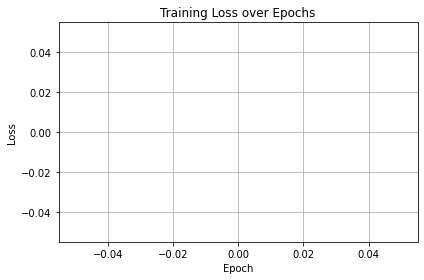

In [10]:
# Initialize model and optimizer
model = CombinedModel()
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 200
batch_size = 4

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = KPDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_val = KPDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = KPDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

top_5_models = []

model.train()
mse_loss = nn.MSELoss()

epoch_losses = []

for epoch in range(num_epochs):  # for 50 epochs
    epoch_loss_accumulated = 0  # to accumulate loss for each batch in the current epoch
    num_batches = 0  # to track the number of batches processed

    for batch_idx, batch in enumerate(data_loader_train):
        images, targets = batch          
        # Move images to GPU
        images = torch.stack(images).cuda()
        imgs = [img.to(device) for img in images]  # Create list of images
        # Move targets to GPU
        for target in targets:
            for key, val in target.items():
                target[key] = val.cuda()
        
        optimizer.zero_grad()
        individual_losses = []
        
       # Automatic mixed precision for forward pass
        with autocast():
            output_train = model(images, targets=targets, train=True)
    
            for i in range(len(images)):
                img = images[i].unsqueeze(0).to(device)
                ground_truth_keypoints = targets[i]['keypoints'].to(device).squeeze()[:,0:2]
                print("ground truth keypoints shape", ground_truth_keypoints)
                optimizer.zero_grad()
                # automatic precision for forward pass
                predicted_keypoints = model(img, train=False)    
                # Compute the loss for this image
                # Compute loss
                loss = mse_loss(predicted_keypoints, ground_truth_keypoints)
                individual_losses.append(loss.item())
            
            # Aggregate the individual losses to get a scalar loss
            scalar_loss = sum(individual_losses) / len(individual_losses)      
            loss_keypoint = output_train['loss_keypoint']
            
            total_loss = scalar_loss + 0.01*loss_keypoint  
        print("total_loss", total_loss)
        
        # Scale the loss and backpropagate
        scaler.scale(total_loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scheduler.step()
        scaler.step(optimizer)
        scaler.update()
        
        # Check if the current model should be saved as a top model
        if len(top_5_models) < 5 or total_loss.item() < max(top_5_models, key=lambda x: x[0])[0]:
            # Save the model state and loss
            model_state = {
                'epoch': epoch,
                'complete_model': model,
#                 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss.item(),
            }
            top_5_models.append((total_loss.item(), model_state))

            # Sort the list based on loss (ascending order)
            top_5_models.sort(key=lambda x: x[0])

            # If there are more than 5 models, remove the one with the highest loss
            if len(top_5_models) > 5:
                top_5_models.pop()
                
        epoch_loss_accumulated += total_loss.item()
        num_batches += 1

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader_train)}, Loss: {total_loss.item()}")
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.item()}")
    
# After all epochs, save the top 5 models to disk
for idx, (_, model_state) in enumerate(top_5_models):
    torch.save(model_state, f'/home/jc-merlab/Pictures/Data/trained_models/vanilla_gnn_model_b{batch_size}_e{num_epochs}_{idx+1}.pth')
    

# After the training loop
plot_training_loss(epoch_losses)